In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
#import plotly.plotly as py
#import plotly

In [2]:
#import plotly.graph_objs as go

In [3]:
delivery_info=pd.read_csv('../data/raw/meta_data/delivery_info.csv', index_col=0)#.astype('datetime64[ns]')

In [4]:
TS_delivery_info = delivery_info[delivery_info.index.str.match('TS')]
TF_delivery_info = delivery_info[delivery_info.index.str.match('TF')]
T_delivery_info = delivery_info[~delivery_info.index.str.match('TS|TF')]

In [5]:
T_OI_total = pd.read_csv('../data/interim/raw_features/T/T_Open_Interest.csv', index_col='Trading_Day', parse_dates=True)
TF_OI_total = pd.read_csv('../data/interim/raw_features/TF/TF_Open_Interest.csv', index_col='Trading_Day', parse_dates=True)

In [6]:
plt.rcParams['figure.figsize'] = [25, 10]

# Functions

In [7]:
def treasury_futures_contracts_sequence(delivery_info):
    
    active_contracts = delivery_info.index.to_series()[:-2].values.reshape(-1,1)
    deferred_contracts = delivery_info.index.to_series()[1:-1].values.reshape(-1,1)
    further_contracts = delivery_info.index.to_series()[2:].values.reshape(-1,1)
    notice_day = delivery_info['notice_day'].values[:-2].reshape(-1,1)
    active_deferred_contracts = np.concatenate((active_contracts, deferred_contracts, further_contracts, notice_day), axis = 1)
    contracts_sequence_df = pd.DataFrame(data = active_deferred_contracts, index = delivery_info['intention_day'][:-2], 
                                       columns = ['active_contract', 'deferred_contract', 'further_contract', 'notice_day'])
    
    return contracts_sequence_df

In [8]:
def get_value_df(contracts_sequence, value, value_name, contract_list):
    
    value_df = pd.DataFrame(columns=['active_contract', 'deferred_contract', 'further_contract', 
                                   'active_contract_'+value_name, 'deferred_contract_'+value_name, 'further_contract_'+value_name])
    
    for i in range(len(contracts_sequence)):
        if i == 0:
            last_notice_day = value.index[0]
        else:
            last_notice_day = contracts_sequence['notice_day'][i-1]

        intention_day = contracts_sequence.index[i]
        active_contract_code = contracts_sequence['active_contract'][i]
        deferred_contract_code = contracts_sequence['deferred_contract'][i]
        further_contract_code = contracts_sequence['further_contract'][i]
        
        if pd.to_datetime(intention_day) <= value.index[-1]:
            current_active_contract_value = value.loc[last_notice_day:intention_day, active_contract_code]
            current_deferred_contract_value = value.loc[last_notice_day:intention_day, deferred_contract_code]
            current_further_contract_value = value.loc[last_notice_day:intention_day, further_contract_code]
            active_contract_code_series = pd.Series(data=active_contract_code, index=current_active_contract_value.index)
            deferred_contract_code_series = pd.Series(data=deferred_contract_code, index=current_deferred_contract_value.index)
            further_contract_code_series = pd.Series(data=further_contract_code, index=current_further_contract_value.index)

        else:
            current_active_contract_value = value.loc[last_notice_day:, active_contract_code]
            current_deferred_contract_value = value.loc[last_notice_day:, deferred_contract_code]
            current_further_contract_value = value.loc[last_notice_day:, further_contract_code]
            
            if current_active_contract_value is not None:
                active_contract_code_series = pd.Series(data=active_contract_code, index=current_active_contract_value.index)
                deferred_contract_code_series = pd.Series(data=deferred_contract_code, index=current_deferred_contract_value.index)
                further_contract_code_series = pd.Series(data=further_contract_code, index=current_further_contract_value.index)
                
        current_data = pd.concat([active_contract_code_series, deferred_contract_code_series, further_contract_code_series, 
                                current_active_contract_value, current_deferred_contract_value, current_further_contract_value], axis=1)   
        current_data.columns = value_df.columns
        value_df = pd.concat([value_df, current_data], axis=0)
        
    last_intention_date = pd.to_datetime(intention_day)
    
    if last_intention_date < value.index[-1]:
        
        current_contract = contracts_sequence.loc[intention_day, 'deferred_contract']
        next_contract = find_next_contract(current_contract, contract_list)
        further_contract = find_next_contract(next_contract, contract_list)
        
        latest_active_contract_value = value.loc[last_intention_date:, current_contract].iloc[1:]
        latest_deferred_contract_value = value.loc[last_intention_date:, next_contract].iloc[1:]
        latest_further_contract_value = value.loc[last_intention_date:, further_contract].iloc[1:]
        
        active_contract_code_series = pd.Series(data=current_contract, index=latest_active_contract_value.index)
        deferred_contract_code_series = pd.Series(data=next_contract, index=latest_deferred_contract_value.index)
        further_contract_code_series = pd.Series(data=further_contract, index=latest_further_contract_value.index)

        current_data = pd.concat([active_contract_code_series, deferred_contract_code_series, further_contract_code_series, 
                                latest_active_contract_value, latest_deferred_contract_value, latest_further_contract_value], axis=1)   
        current_data.columns = value_df.columns
        
        value_df = pd.concat([value_df, current_data], axis=0)
        
    value_df.index.name='Trading_Day'
    
    return value_df

In [9]:
def get_case(idx, idx_list):
    sr = pd.Series(range(len(idx)), index=idx)
    return list(sr.reindex(idx_list).dropna().astype('int').values)

In [10]:
def n_days_earlier(case, n):
    return [num - n for num in case]

In [11]:
def plot_roll_period(n_days, value, delivery_info, days_before_intention=0, left_boundary=None, right_boundary=None):
    
    if left_boundary:
        value = value[left_boundary:]
    if right_boundary:
        value = value[:right_boundary]
    
    intention_day_list = []
    for i, intention_day in enumerate(delivery_info.astype('datetime64[ns]')['intention_day']):
        if intention_day in value.index:
            intention_day_list.append(intention_day)
    
    case_ = get_case(value.index, intention_day_list)
    case = [x + days_before_intention for x in case_]
    plt.plot(value.index, value, '.', ls='-', mfc='orange', mec='orange', ms=15, markevery=case)
    
    for i, idx in enumerate(case):
        value[idx-n_days+1:idx+1].plot(c='orange')
        
    plt.show()
    
    return case, value

In [12]:
def draw_roll_period_only(spread_data, fraction_data, contracts_sequence, delivery_info, contract_list, n_days, 
                          fraction='OI', spread='close', fraction_type='active', choose_fraction=True):
    
    spread_df = get_value_df(contracts_sequence, spread_data, spread, contract_list)
    spread_df['spread'] = spread_df['active_contract_'+spread] - spread_df['deferred_contract_'+spread]
    
    fraction_df = get_value_df(contracts_sequence, fraction_data, fraction, contract_list)
    
    if choose_fraction:
        fraction_sr = fraction_df[fraction_type+'_contract_'+fraction] / fraction_data.sum(axis=1)
    else:
        fraction_sr = fraction_df[fraction_type+'_contract_'+fraction]
    
    fig, ax = plt.subplots(math.ceil((delivery_info.shape[0] - 3) / 4), 4, figsize=(18, 18))

    for i, intention_day in enumerate(delivery_info.astype('datetime64[ns]')['intention_day'][:-3]):
        j = int(i / 4)
        k = i % 4
        ax2 = ax[j][k].twinx()
        
        fraction_sample = fraction_sr[:intention_day][-n_days:]
        ax[j][k].plot(range(-n_days+1, 1), fraction_sample, c='g')
        
        spread_sample = spread_df['spread'][:intention_day][-n_days:]
        ax2.plot(range(-n_days+1, 1), spread_sample, c='pink')
        ax2.axhline(y=0)

        ax[j][k].set_xlabel("Trading day")
        ax[j][k].set_ylabel(fraction_type+'_contract_'+fraction+'_fraction_', color='g')
        ax2.set_ylabel(spread+'_spread', color='pink')
        ax[j][k].set_title(str(i+1)+'th '+str(intention_day.date()))

    plt.tight_layout()
    plt.plot()
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(fraction_sr.index, fraction_sr, c='g')

    ax2.plot(spread_df.index, spread_df['spread'], c='pink')
    plt.axhline(y = 0)
    for intention_day in delivery_info.astype('datetime64[ns]')['intention_day'][:-3]:
        plt.axvline(x=intention_day)

    ax1.set_xlabel('trading day')
    ax1.set_ylabel('fraction data', color='g')
    ax2.set_ylabel('spread data', color='pink')
    ax1.set_title('fraction and spread')
    plt.show()
    return

# Get continuous data

In [15]:
T_delivery_info

intention_day  notice_day delivery_day
T1509    2015-08-28  2015-08-31   2015-09-01
T1512    2015-11-27  2015-11-30   2015-12-01
T1603    2016-02-26  2016-02-29   2016-03-01
T1606    2016-05-30  2016-05-31   2016-06-01
T1609    2016-08-30  2016-08-31   2016-09-01
T1612    2016-11-29  2016-11-30   2016-12-01
T1703    2017-02-27  2017-02-28   2017-03-01
T1706    2017-05-26  2017-05-31   2017-06-01
T1709    2017-08-30  2017-08-31   2017-09-01
T1712    2017-11-29  2017-11-30   2017-12-01
T1803    2018-02-27  2018-02-28   2018-03-01
T1806    2018-05-30  2018-05-31   2018-06-01
T1809    2018-08-30  2018-08-31   2018-09-03
T1812    2018-11-29  2018-11-30   2018-12-03
T1903    2019-02-27  2019-02-28   2019-03-01
T1906    2019-05-30  2019-05-31   2019-06-03
T1909    2019-08-29  2019-08-30   2019-09-02
T1912    2019-11-28  2019-11-29   2019-12-02
T2003    2020-02-27  2020-02-28   2020-03-02

In [13]:
T_contracts_sequence = treasury_futures_contracts_sequence(T_delivery_info)
TF_contracts_sequence = treasury_futures_contracts_sequence(TF_delivery_info)

In [14]:
T_contracts_sequence

active_contract deferred_contract further_contract  notice_day
intention_day                                                               
2015-08-28              T1509             T1512            T1603  2015-08-31
2015-11-27              T1512             T1603            T1606  2015-11-30
2016-02-26              T1603             T1606            T1609  2016-02-29
2016-05-30              T1606             T1609            T1612  2016-05-31
2016-08-30              T1609             T1612            T1703  2016-08-31
2016-11-29              T1612             T1703            T1706  2016-11-30
2017-02-27              T1703             T1706            T1709  2017-02-28
2017-05-26              T1706             T1709            T1712  2017-05-31
2017-08-30              T1709             T1712            T1803  2017-08-31
2017-11-29              T1712             T1803            T1806  2017-11-30
2018-02-27              T1803             T1806            T1809  2018-02-28
2018-05-30              T1806             T1809            T1812  2018-05-31
2018-08-30              T1809             T1812            T1903  2018-08-31
2018-11-29              T1812             T1903            T1906  2018-11-30
2019-02-27              T1903             T1906            T1909  2019-02-28
2019-05-30              T1906             T1909            T1912  2019-05-31
2019-08-29              T1909             T1912            T2003  2019-08-30

## Open Interest

In [15]:
T_contract_list = list(T_open_interest.columns)
TF_contract_list = list(TF_open_interest.columns)

In [16]:
T_open_interest = pd.read_csv('../data/interim/raw_features/T/T_Open_Interest.csv', index_col=0, parse_dates=True)
TF_open_interest = pd.read_csv('../data/interim/raw_features/TF/TF_Open_Interest.csv', index_col=0, parse_dates=True)
T_open_interest_df = get_value_df(T_contracts_sequence, T_open_interest, 'open_interest', T_contract_list)
TF_open_interest_df = get_value_df(TF_contracts_sequence, TF_open_interest, 'open_interest', TF_contract_list)

In [26]:
T_open_interest_df.to_csv('../data/processed/open_interest/T_open_interest_continuous.csv')
TF_open_interest_df.to_csv('../data/processed/open_interest/TF_open_interest_continuous.csv')

## Close Price

In [22]:
T_close = pd.read_csv('../data/interim/raw_features/T/T_Close.csv', index_col=0, parse_dates=True)
TF_close = pd.read_csv('../data/interim/raw_features/TF/TF_Close.csv', index_col=0, parse_dates=True)
T_close_df = get_value_df(T_contracts_sequence, T_close, 'close', T_contract_list)
TF_close_df = get_value_df(TF_contracts_sequence, TF_close, 'close', TF_contract_list)

In [23]:
T_close_df.to_csv('../data/processed/close/T_close_continuous.csv')
TF_close_df.to_csv('../data/processed/close/TF_close_continuous.csv')

## Settle

In [29]:
T_settle = pd.read_csv('../data/interim/raw_features/T/T_settle.csv', index_col=0, parse_dates=True)
TF_settle = pd.read_csv('../data/interim/raw_features/TF/TF_settle.csv', index_col=0, parse_dates=True)
T_settle_df = get_value_df(T_contracts_sequence, T_settle, 'settle', T_contract_list)
TF_settle_df = get_value_df(TF_contracts_sequence, TF_settle, 'settle', TF_contract_list)

In [30]:
T_settle_df.to_csv('../data/processed/settle/T_settle_continuous.csv')
TF_settle_df.to_csv('../data/processed/settle/TF_settle_continuous.csv')

## Posted Size

In [18]:
T_posted_size = pd.read_csv('../data/processed/posted_size/T_posted_size.csv', index_col='Trading_Day', parse_dates=True)
TF_posted_size = pd.read_csv('../data/processed/posted_size/TF_posted_size.csv', index_col='Trading_Day', parse_dates=True)
T_posted_size_df = get_value_df(T_contracts_sequence, T_posted_size, 'posted_size', T_contract_list)
TF_posted_size_df = get_value_df(TF_contracts_sequence, TF_posted_size, 'posted_size', TF_contract_list)

In [19]:
T_posted_size_df.to_csv('../data/processed/posted_size/T_posted_size_continuous.csv')
TF_posted_size_df.to_csv('../data/processed/posted_size/TF_posted_size_continuous.csv')

## Posted Size Fraction

In [20]:
T_posted_size_fraction = pd.read_csv('../data/processed/posted_size/T_posted_size_fraction.csv', index_col='Trading_Day', parse_dates=True)
TF_posted_size_fraction = pd.read_csv('../data/processed/posted_size/TF_posted_size_fraction.csv', index_col='Trading_Day', parse_dates=True)
T_posted_size_fraction_df = get_value_df(T_contracts_sequence, T_posted_size_fraction, 'posted_size_fraction', T_contract_list)
TF_posted_size_fraction_df = get_value_df(TF_contracts_sequence, TF_posted_size_fraction, 'posted_size_fraction', TF_contract_list)

In [21]:
T_posted_size_fraction_df.to_csv('../data/processed/posted_size/T_posted_size_fraction_continuous.csv')
TF_posted_size_fraction_df.to_csv('../data/processed/posted_size/TF_posted_size_fraction_continuous.csv')

# T Open Interest

In [36]:
T_open_interest_df['open_interest_sum'] = T_open_interest_df['active_contract_open_interest'] + T_open_interest_df['deferred_contract_open_interest']

In [37]:
T_OI_fraction = T_open_interest_df['open_interest_sum'] / T_OI_total.sum(axis=1)

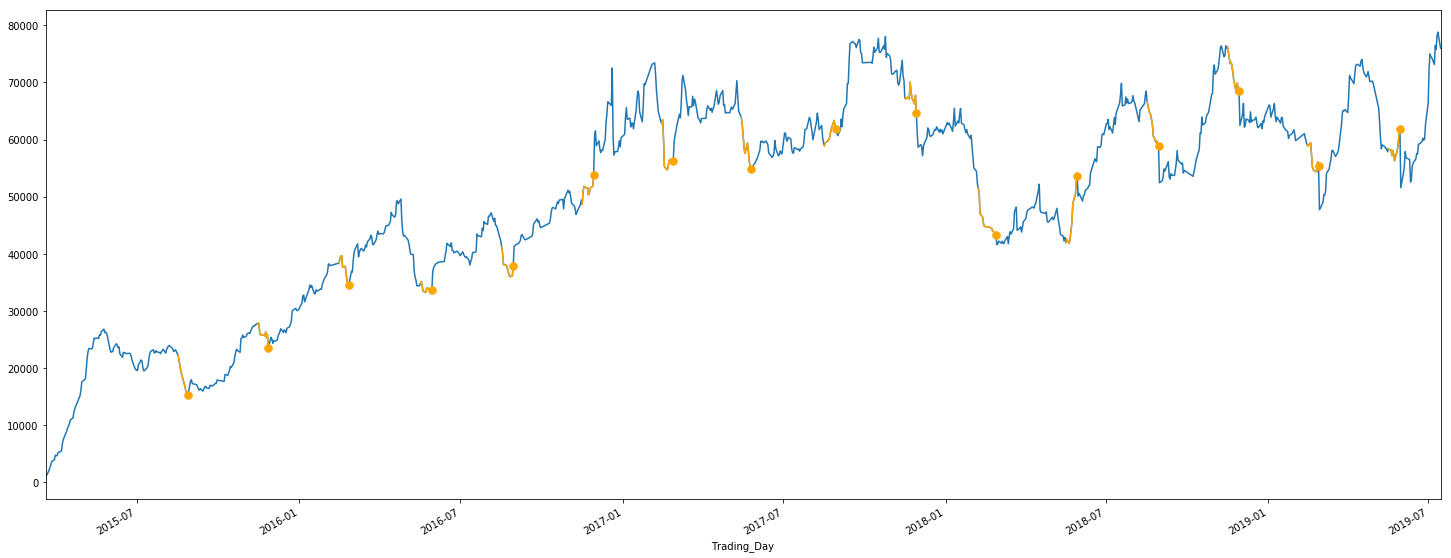

In [44]:
idx_list, value = plot_roll_period(10, T_open_interest_df['open_interest_sum'], T_delivery_info)

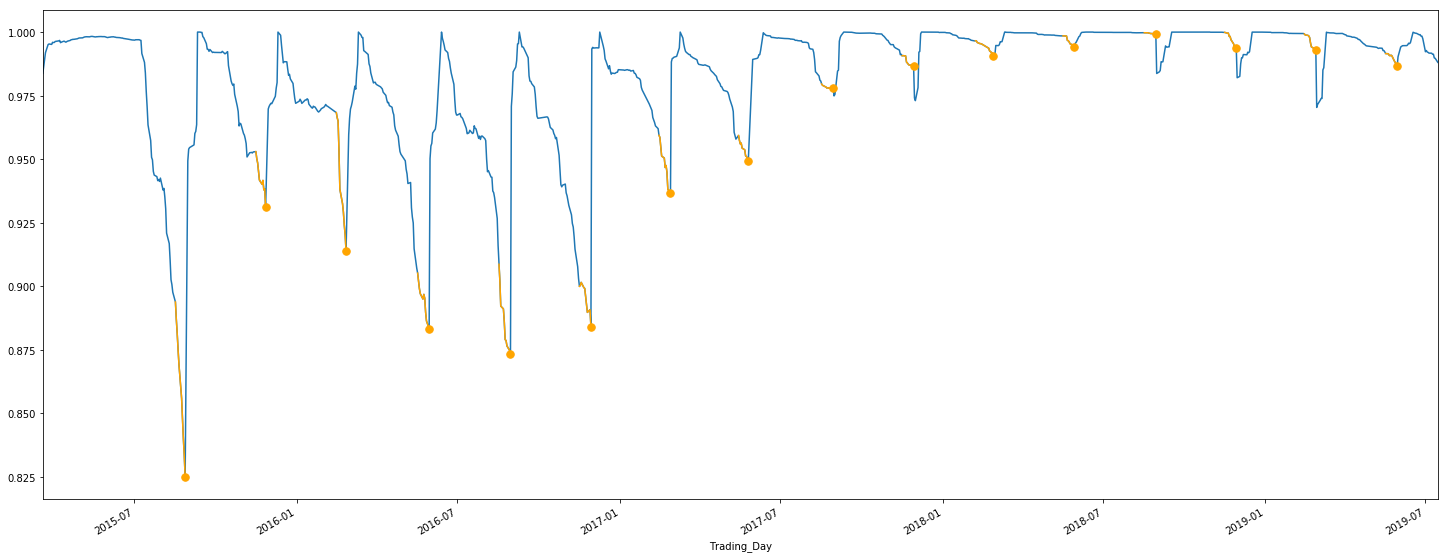

In [43]:
idx_list, value = plot_roll_period(10, T_OI_fraction, T_delivery_info)#, left_boundary='2016-08-01', right_boundary='2016-10-01')

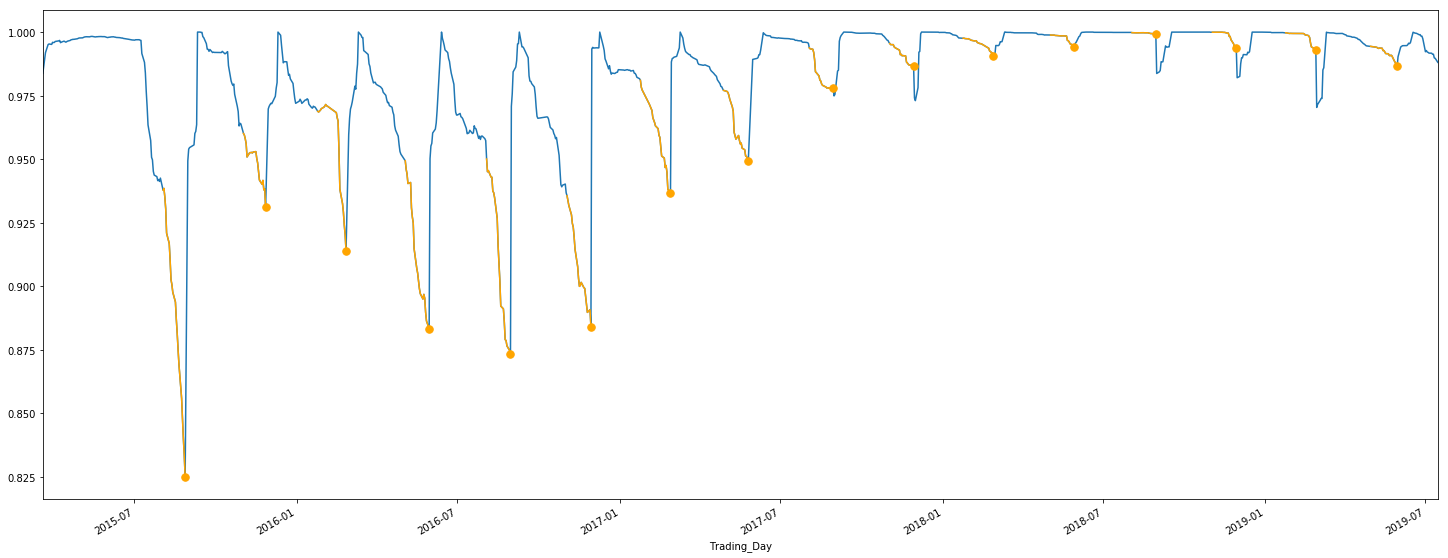

In [45]:
idx_list, value = plot_roll_period(20, T_OI_fraction, T_delivery_info)#, left_boundary='2016-08-01', right_boundary='2016-10-01')

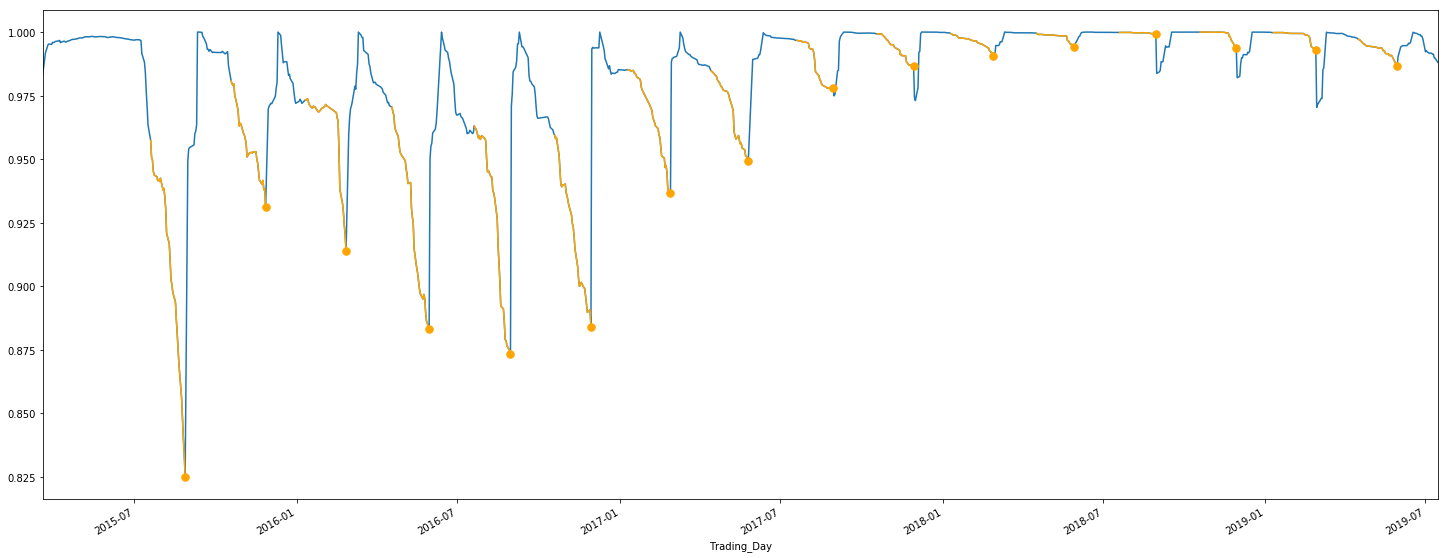

In [46]:
idx_list, value = plot_roll_period(30, T_OI_fraction, T_delivery_info)#, left_boundary='2016-08-01', right_boundary='2016-10-01')

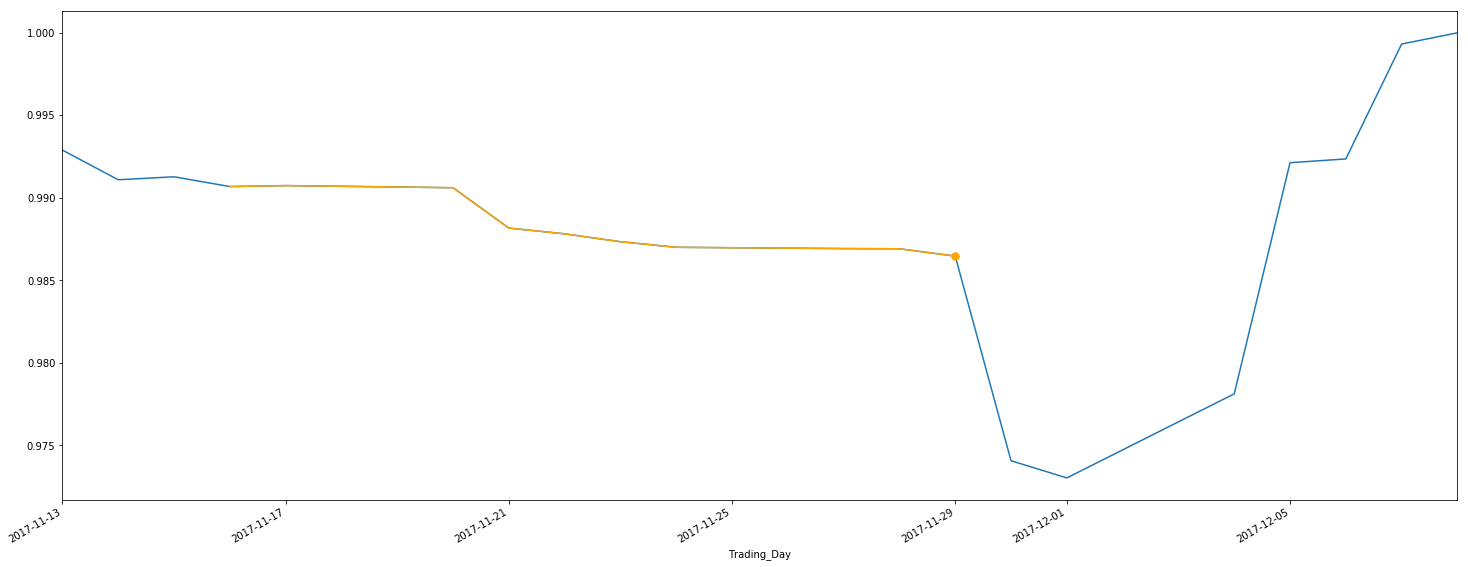

In [47]:
idx_list, value = plot_roll_period(10, T_OI_fraction, T_delivery_info, left_boundary='2017-11-11', right_boundary='2017-12-08')

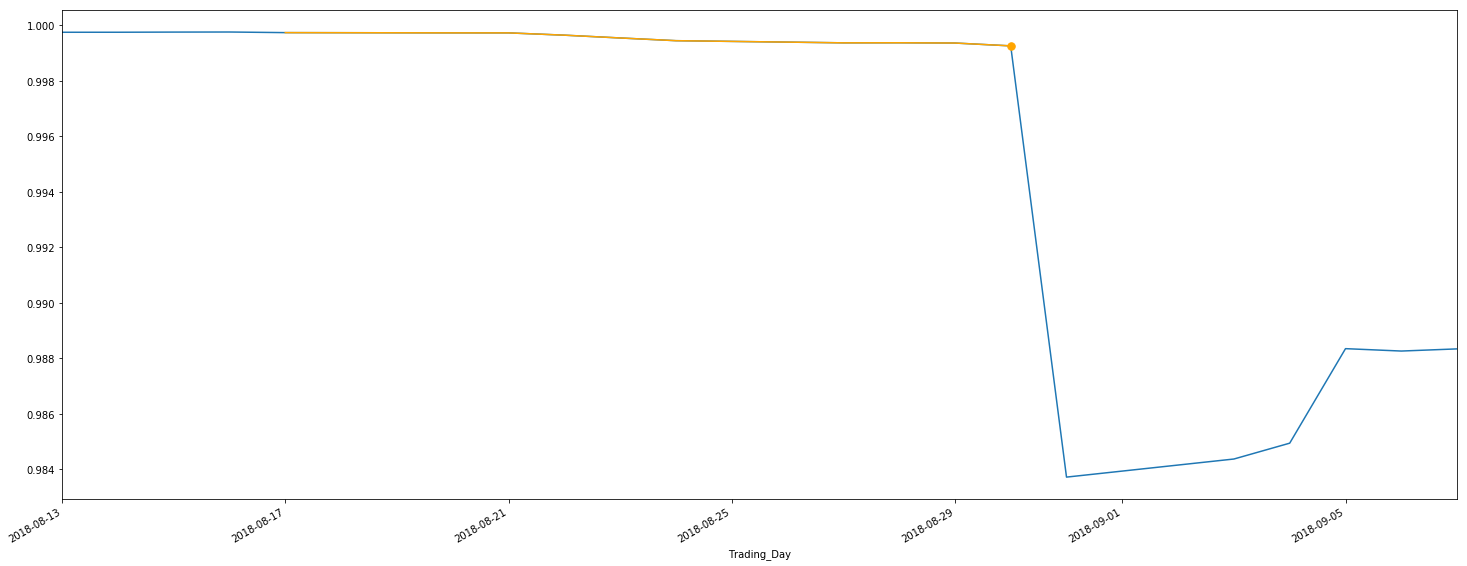

In [48]:
idx_list, value = plot_roll_period(10, T_OI_fraction, T_delivery_info, left_boundary='2018-08-13', right_boundary='2018-09-08')

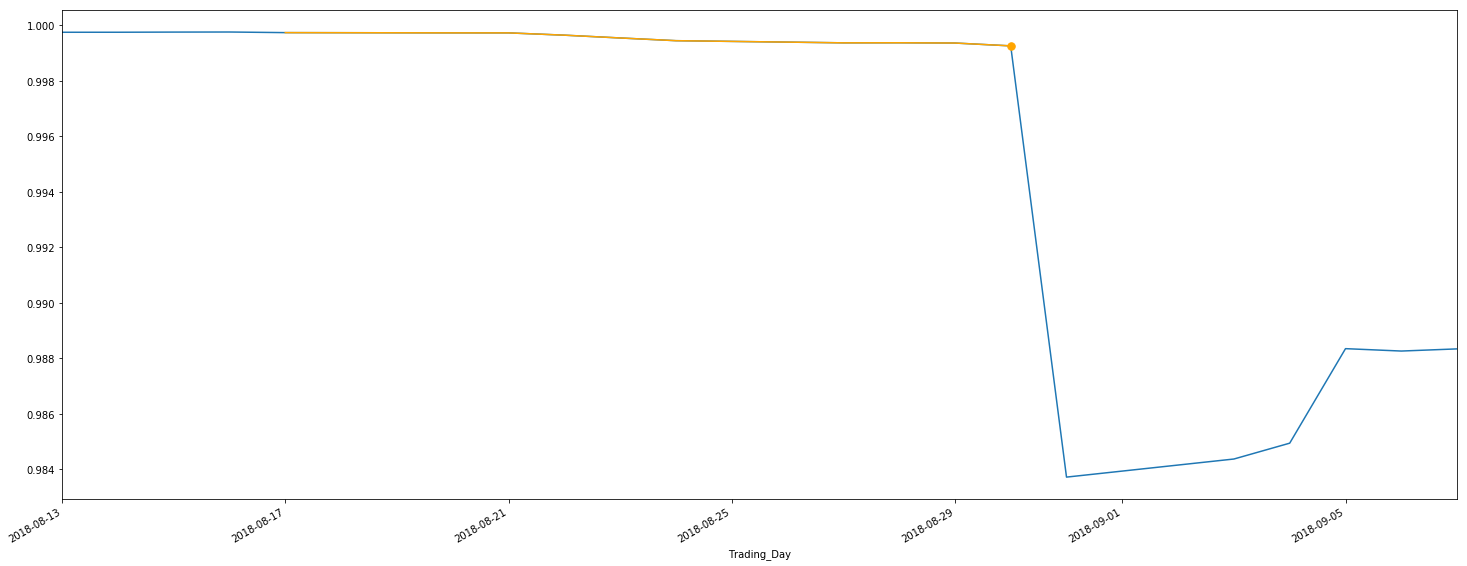

In [49]:
idx_list, value = plot_roll_period(10, T_OI_fraction, T_delivery_info, left_boundary='2018-08-13', right_boundary='2018-09-08')

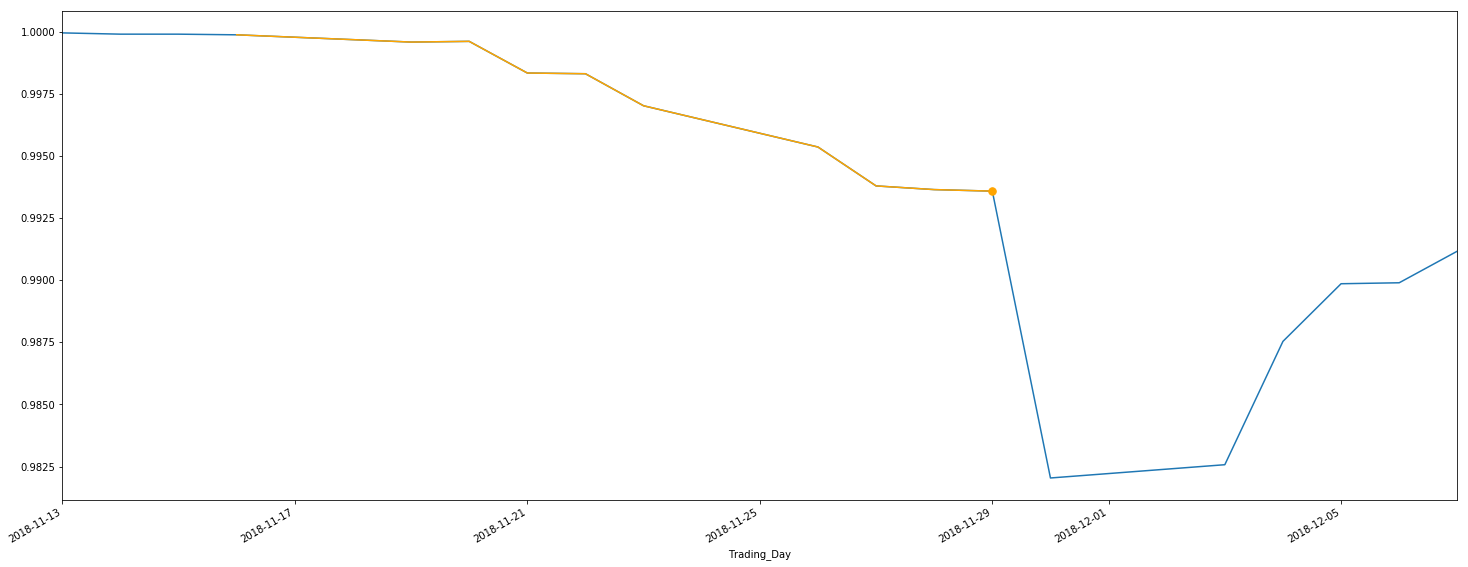

In [50]:
idx_list, value = plot_roll_period(10, T_OI_fraction, T_delivery_info, left_boundary='2018-11-13', right_boundary='2018-12-08')

# TF Open Interest

In [53]:
TF_open_interest_df['open_interest_sum'] = TF_open_interest_df['active_contract_open_interest'] + TF_open_interest_df['deferred_contract_open_interest']
TF_OI_fraction = TF_open_interest_df['open_interest_sum'] / TF_OI_total.sum(axis=1)

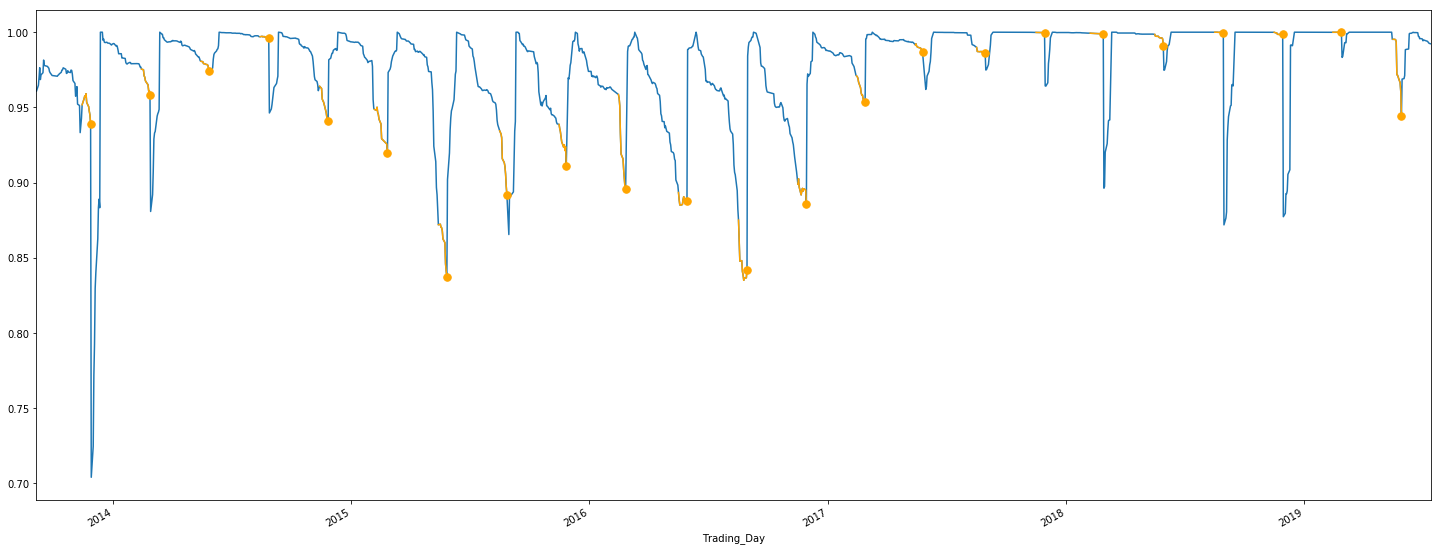

In [54]:
idx_list, value = plot_roll_period(10, TF_OI_fraction, TF_delivery_info)#, left_boundary='2016-08-01', right_boundary='2016-10-01')

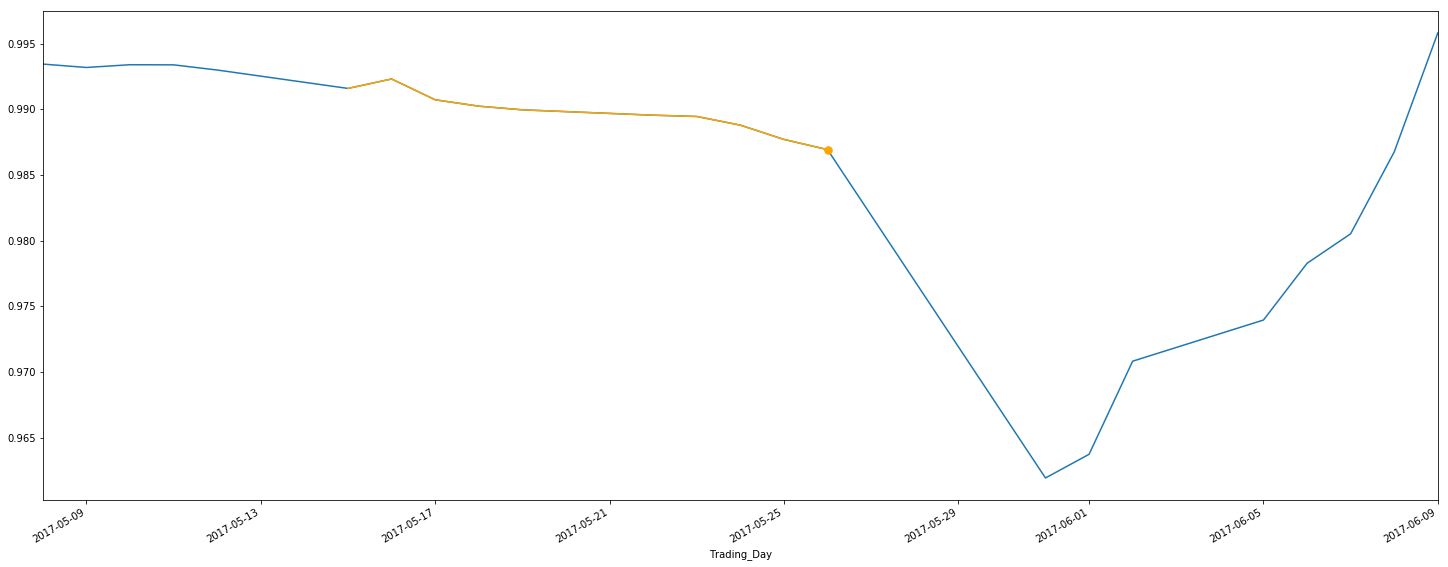

In [61]:
idx_list, value = plot_roll_period(10, TF_OI_fraction, TF_delivery_info, left_boundary='2017-05-08', right_boundary='2017-06-10')

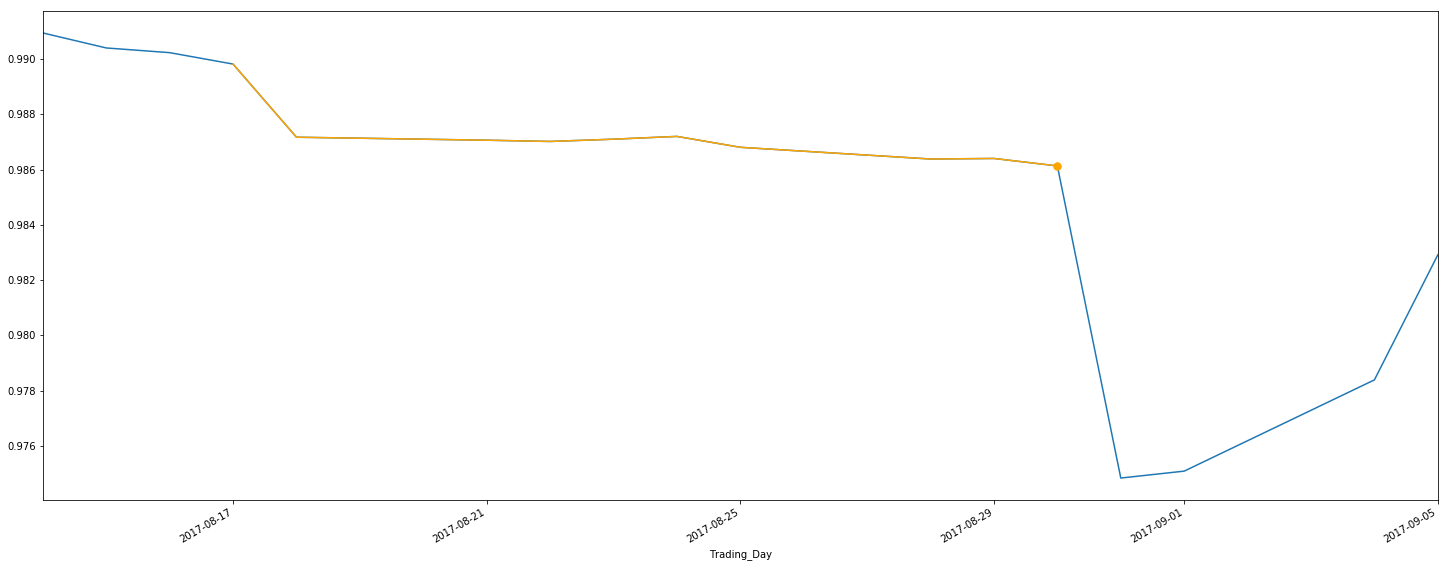

In [62]:
idx_list, value = plot_roll_period(10, TF_OI_fraction, TF_delivery_info, left_boundary='2017-08-13', right_boundary='2017-9-5')

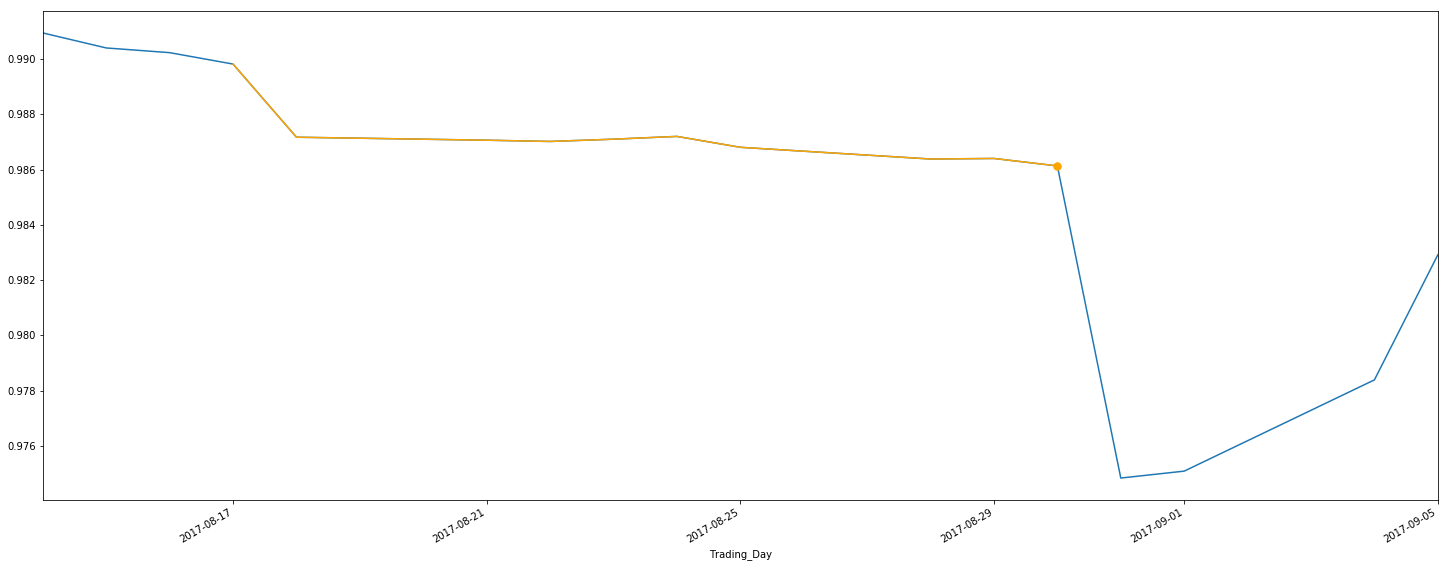

In [63]:
idx_list, value = plot_roll_period(10, TF_OI_fraction, TF_delivery_info, left_boundary='2017-08-13', right_boundary='2017-9-5')

# T Close Spread

In [64]:
T_close_df['close_spread'] = T_close_df['active_contract_close'] - T_close_df['deferred_contract_close']

In [65]:
T_close_df.head()

active_contract deferred_contract further_contract  \
Trading_Day                                                      
2015-03-20            T1509             T1512            T1603   
2015-03-23            T1509             T1512            T1603   
2015-03-24            T1509             T1512            T1603   
2015-03-25            T1509             T1512            T1603   
2015-03-26            T1509             T1512            T1603   

             active_contract_close  deferred_contract_close  \
Trading_Day                                                   
2015-03-20                   97.09                   97.435   
2015-03-23                   97.02                   97.435   
2015-03-24                   96.92                   97.435   
2015-03-25                   96.85                   97.500   
2015-03-26                   96.37                   97.000   

             further_contract_close  close_spread  
Trading_Day                                        
2015-03-20                   97.785        -0.345  
2015-03-23                   97.100        -0.415  
2015-03-24                   97.580        -0.515  
2015-03-25                   97.580        -0.650  
2015-03-26                   97.580        -0.630

## T Close Spread and Open Interest Fraction

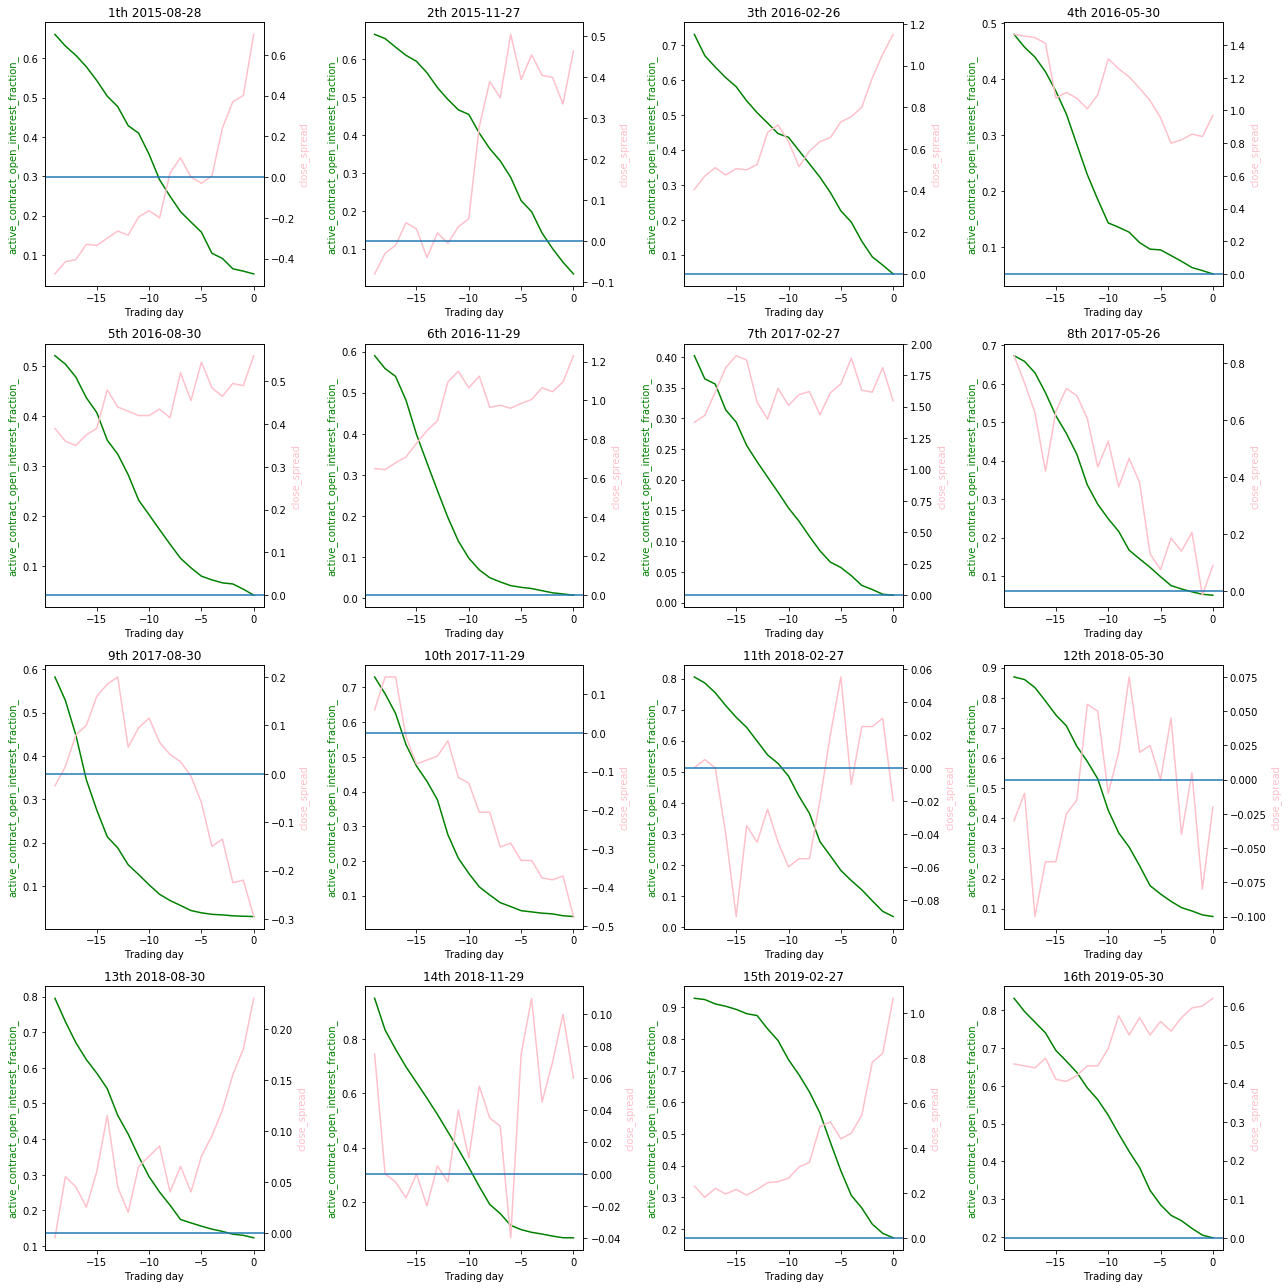

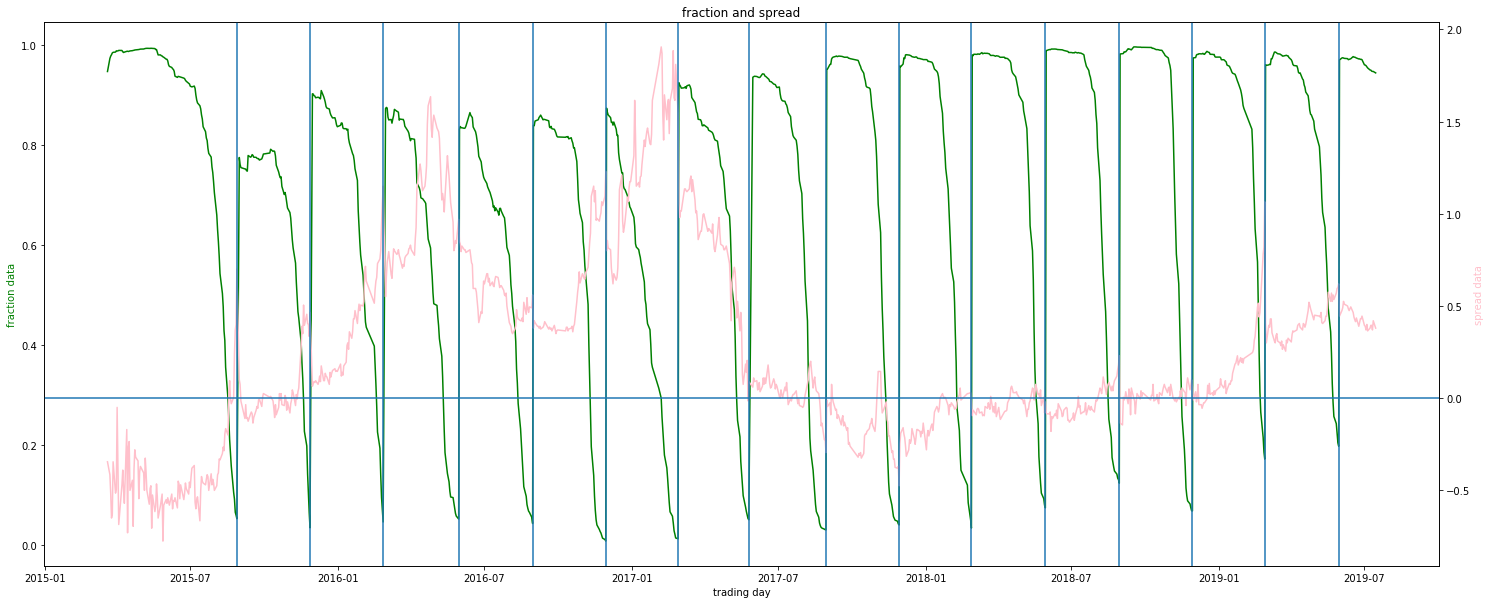

In [71]:
T_spread_data = pd.read_csv('../data/interim/raw_features/T/T_Close.csv', index_col='Trading_Day', parse_dates=True)
T_fraction_data = pd.read_csv('../data/interim/raw_features/T/T_Open_interest.csv', index_col='Trading_Day', parse_dates=True)
draw_roll_period_only(T_spread_data, T_fraction_data, T_contracts_sequence, T_delivery_info, T_contract_list, 20, 
                          fraction='open_interest', spread='close', fraction_type='active')

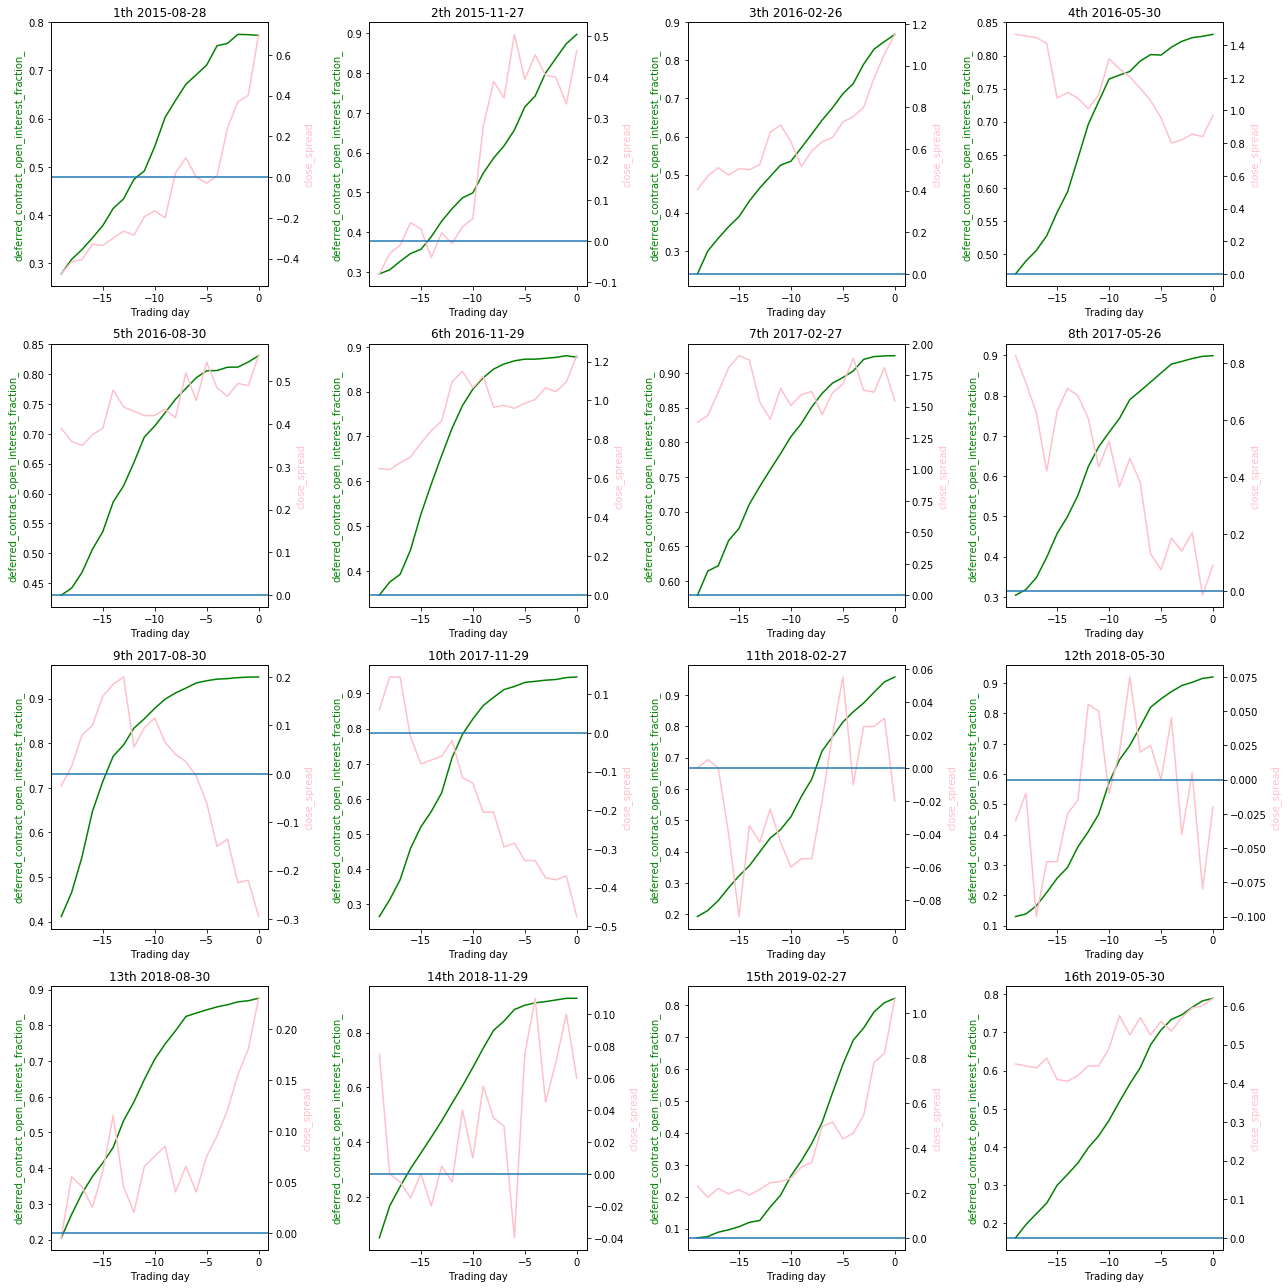

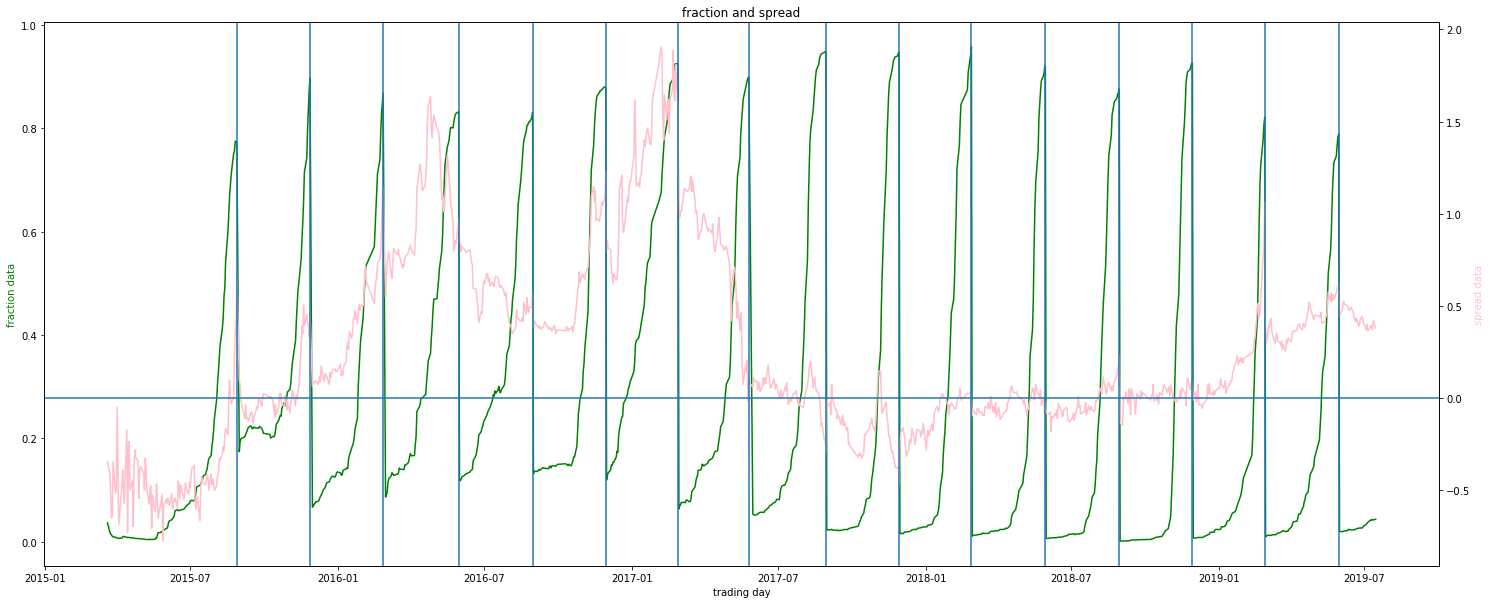

In [70]:
T_spread_data = pd.read_csv('../data/interim/raw_features/T/T_Close.csv', index_col='Trading_Day', parse_dates=True)
T_fraction_data = pd.read_csv('../data/interim/raw_features/T/T_Open_interest.csv', index_col='Trading_Day', parse_dates=True)
draw_roll_period_only(T_spread_data, T_fraction_data, T_contracts_sequence, T_delivery_info, T_contract_list, 20, 
                          fraction='open_interest', spread='close', fraction_type='deferred')

# TF Close Spread and Open Interest Fraction

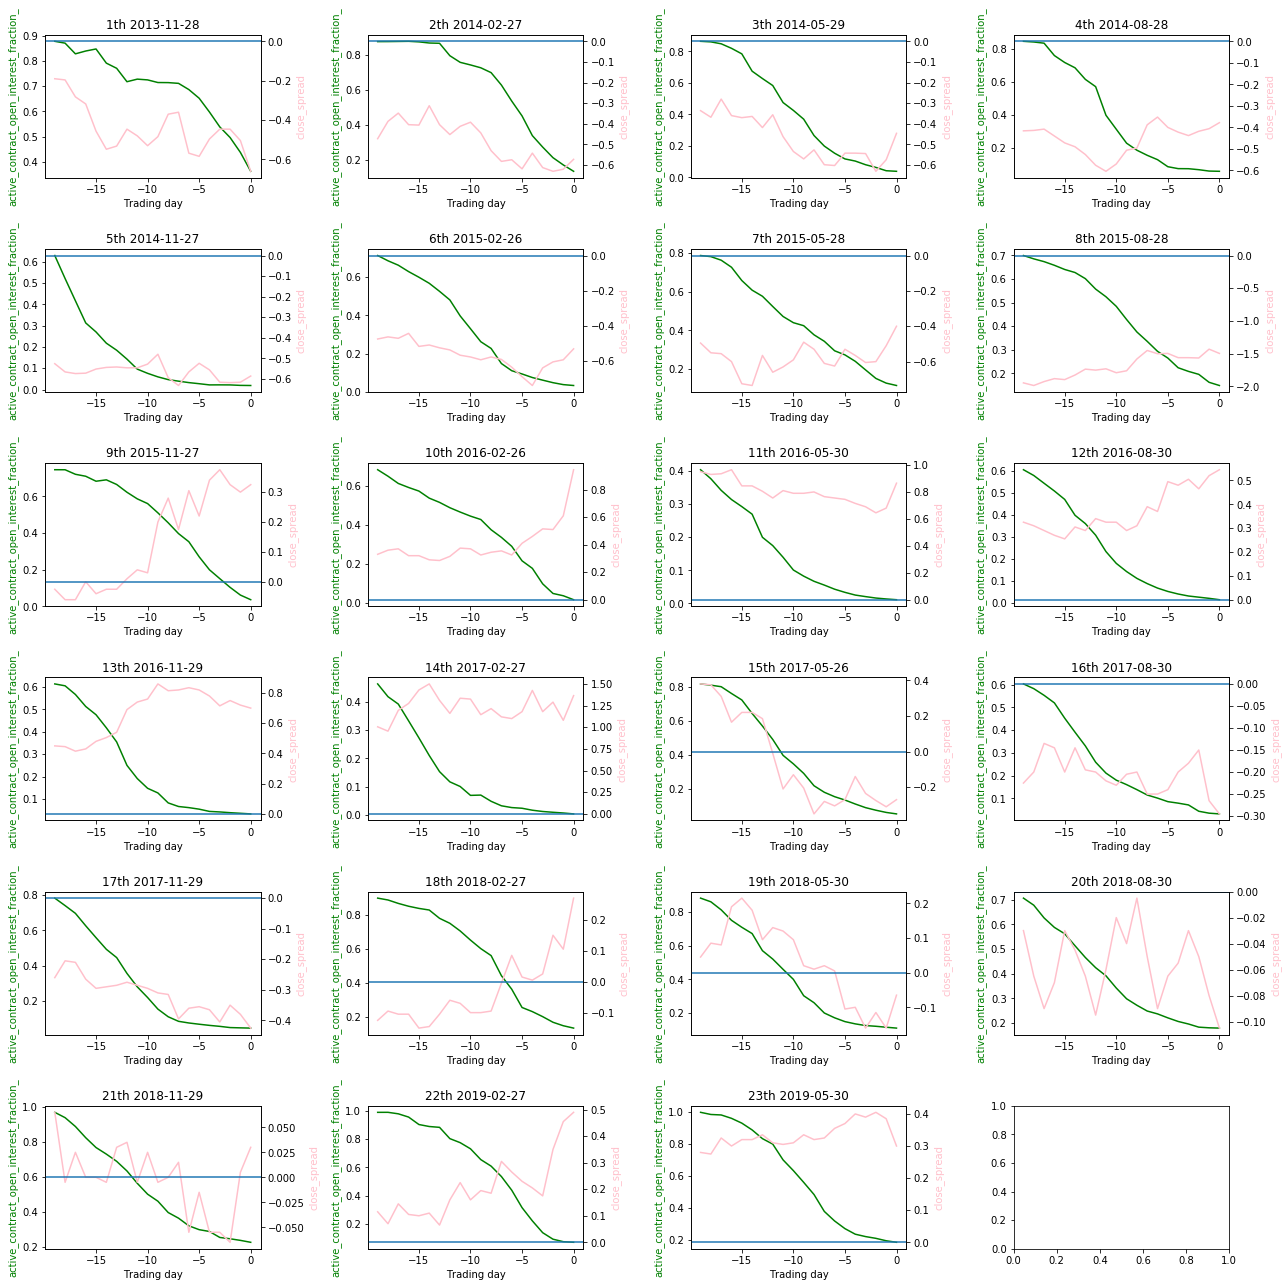

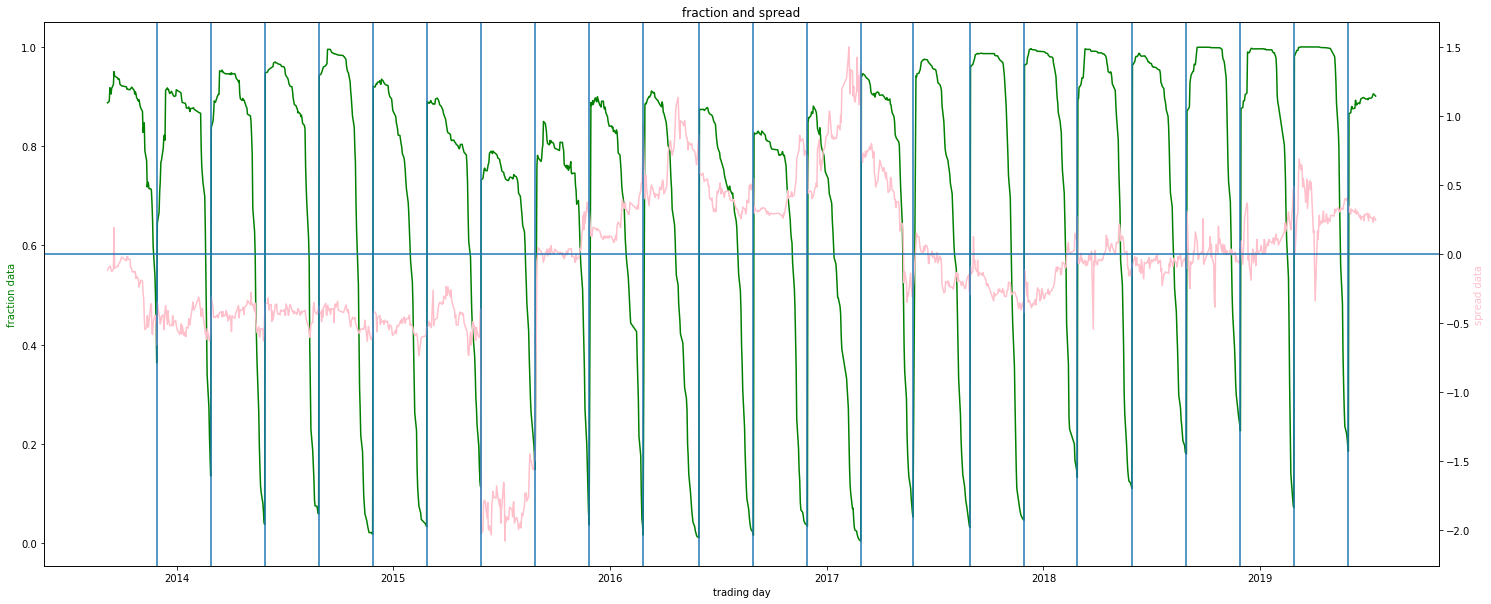

In [73]:
TF_spread_data = pd.read_csv('../data/interim/raw_features/TF/TF_Close.csv', index_col='Trading_Day', parse_dates=True)
TF_fraction_data = pd.read_csv('../data/interim/raw_features/TF/TF_Open_interest.csv', index_col='Trading_Day', parse_dates=True)
draw_roll_period_only(TF_spread_data, TF_fraction_data, TF_contracts_sequence, TF_delivery_info, TF_contract_list, 20, 
                          fraction='open_interest', spread='close', fraction_type='active')

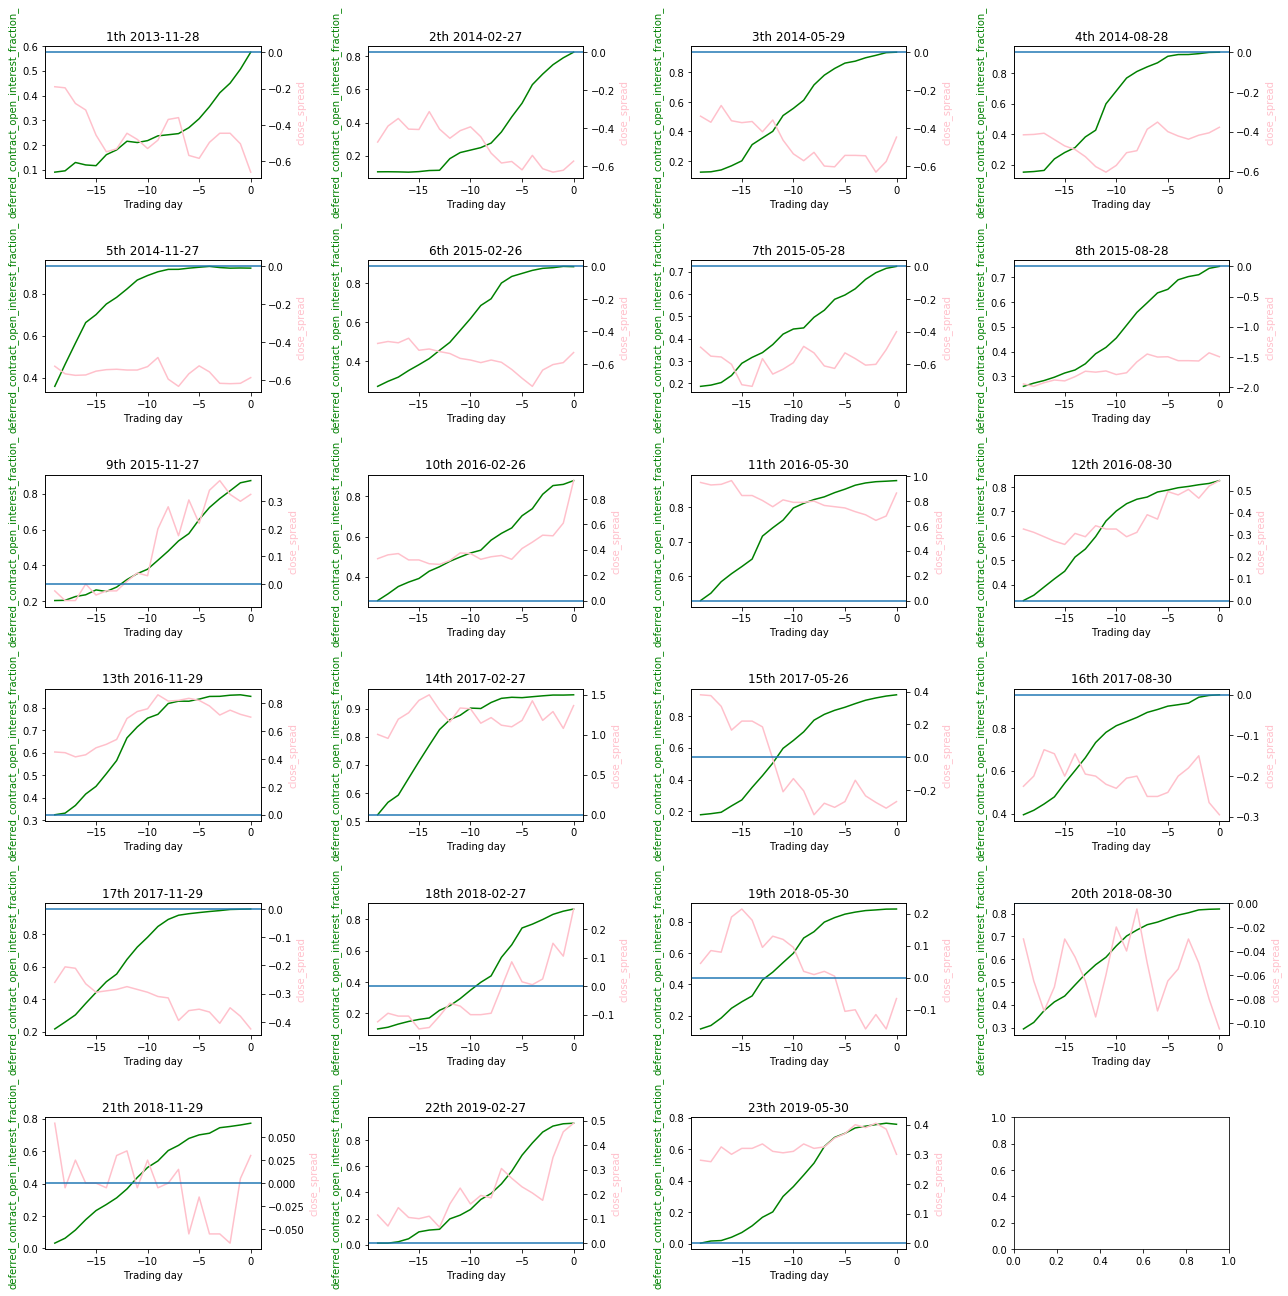

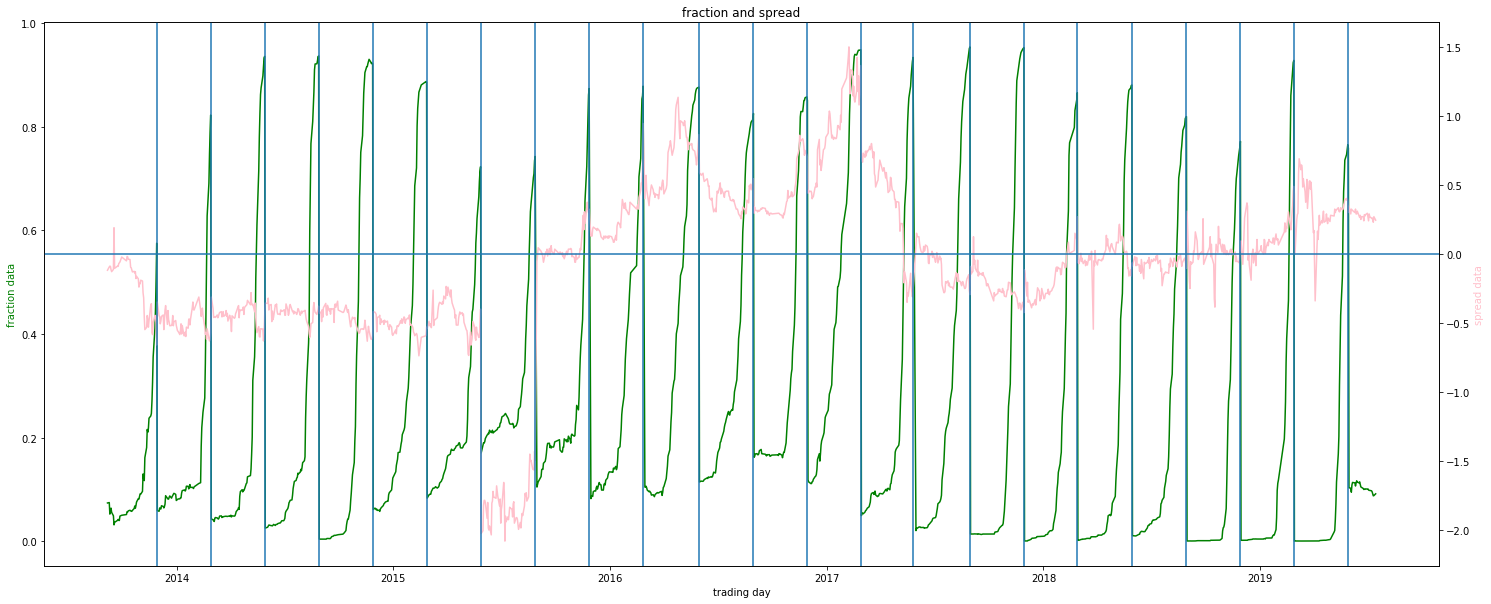

In [74]:
TF_spread_data = pd.read_csv('../data/interim/raw_features/TF/TF_Close.csv', index_col='Trading_Day', parse_dates=True)
TF_fraction_data = pd.read_csv('../data/interim/raw_features/TF/TF_Open_interest.csv', index_col='Trading_Day', parse_dates=True)
draw_roll_period_only(TF_spread_data, TF_fraction_data, TF_contracts_sequence, TF_delivery_info, TF_contract_list, 20, 
                          fraction='open_interest', spread='close', fraction_type='deferred')

# T Posted Size

In [75]:
T_spread_data = pd.read_csv('../data/interim/raw_features/T/T_Settle.csv', index_col='Trading_Day', parse_dates=True)
T_fraction_data = pd.read_csv('../data/interim/raw_features/T/T_Posted_Size.csv', index_col='Trading_Day', parse_dates=True)

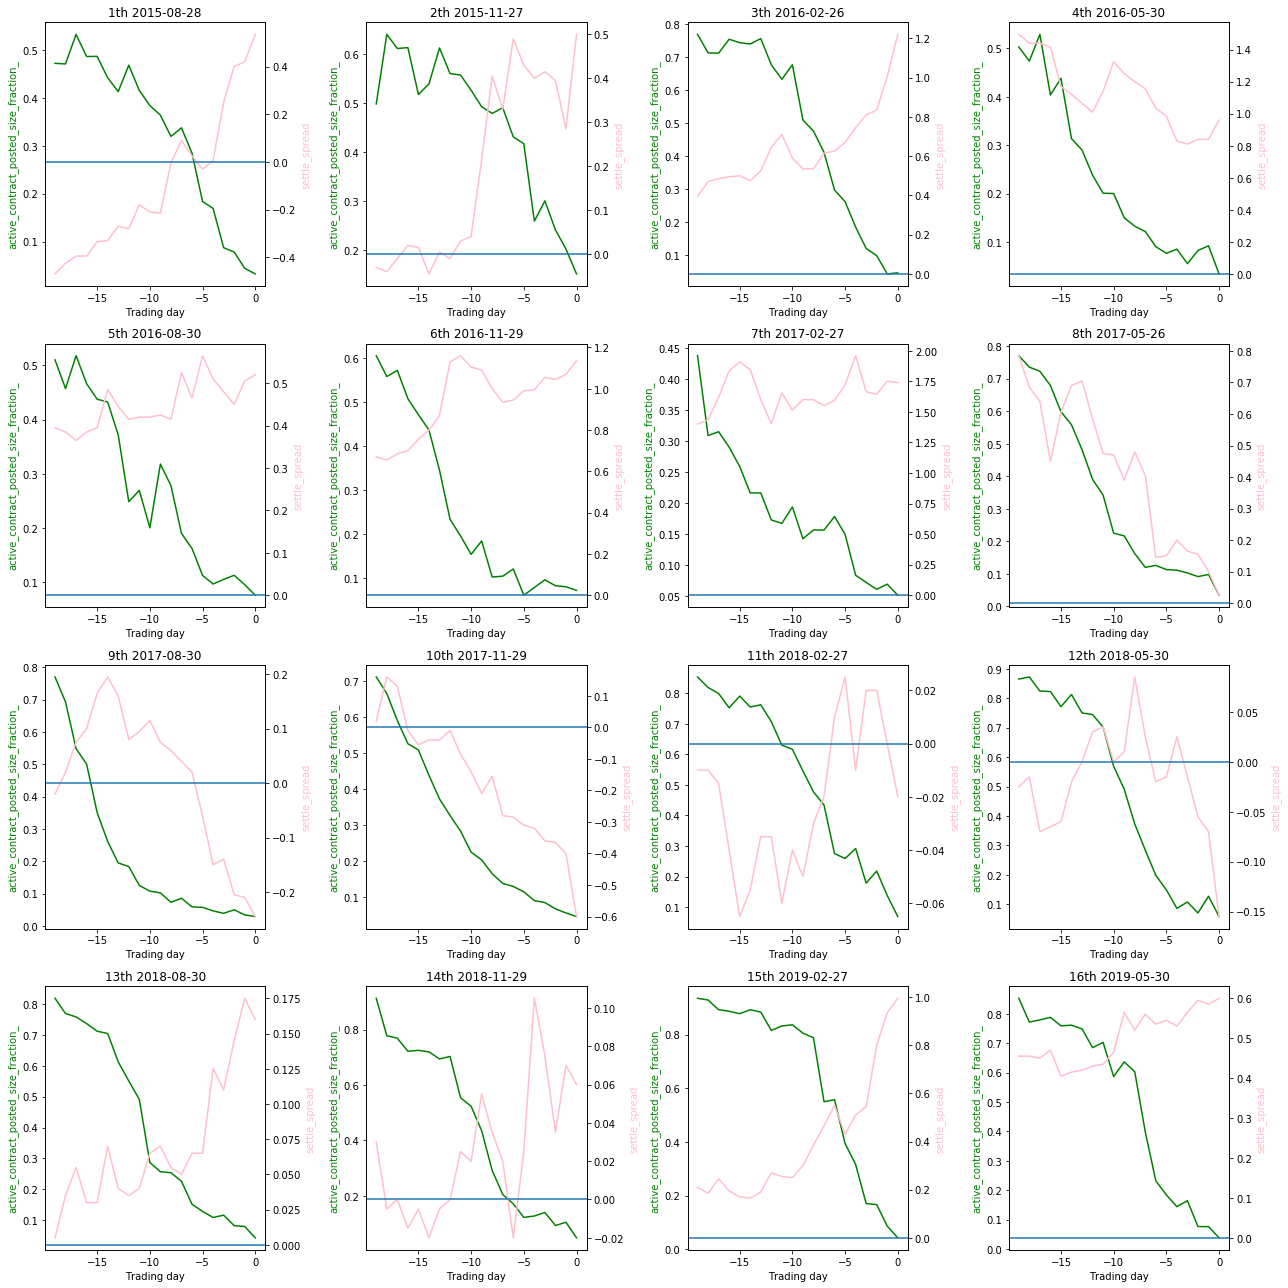

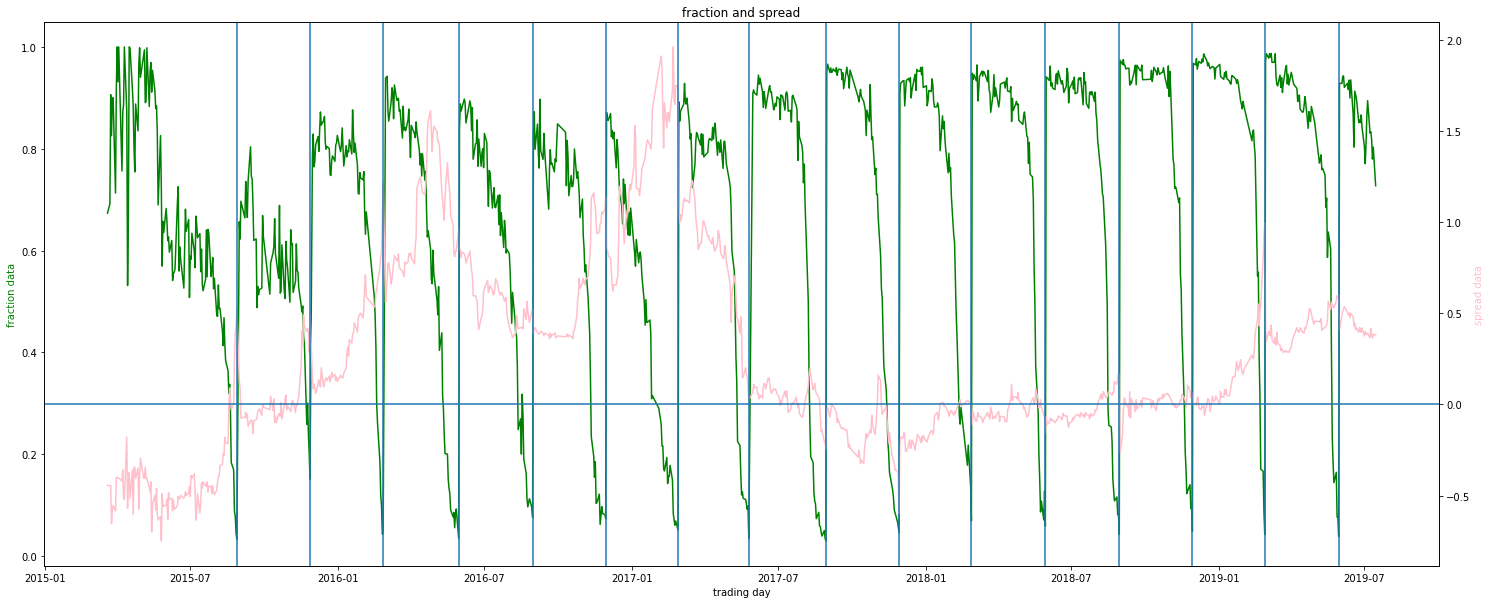

In [77]:
draw_roll_period_only(T_spread_data, T_fraction_data, T_contracts_sequence, T_delivery_info, T_contract_list, 20, 
                          fraction='posted_size', spread='settle', fraction_type='active')

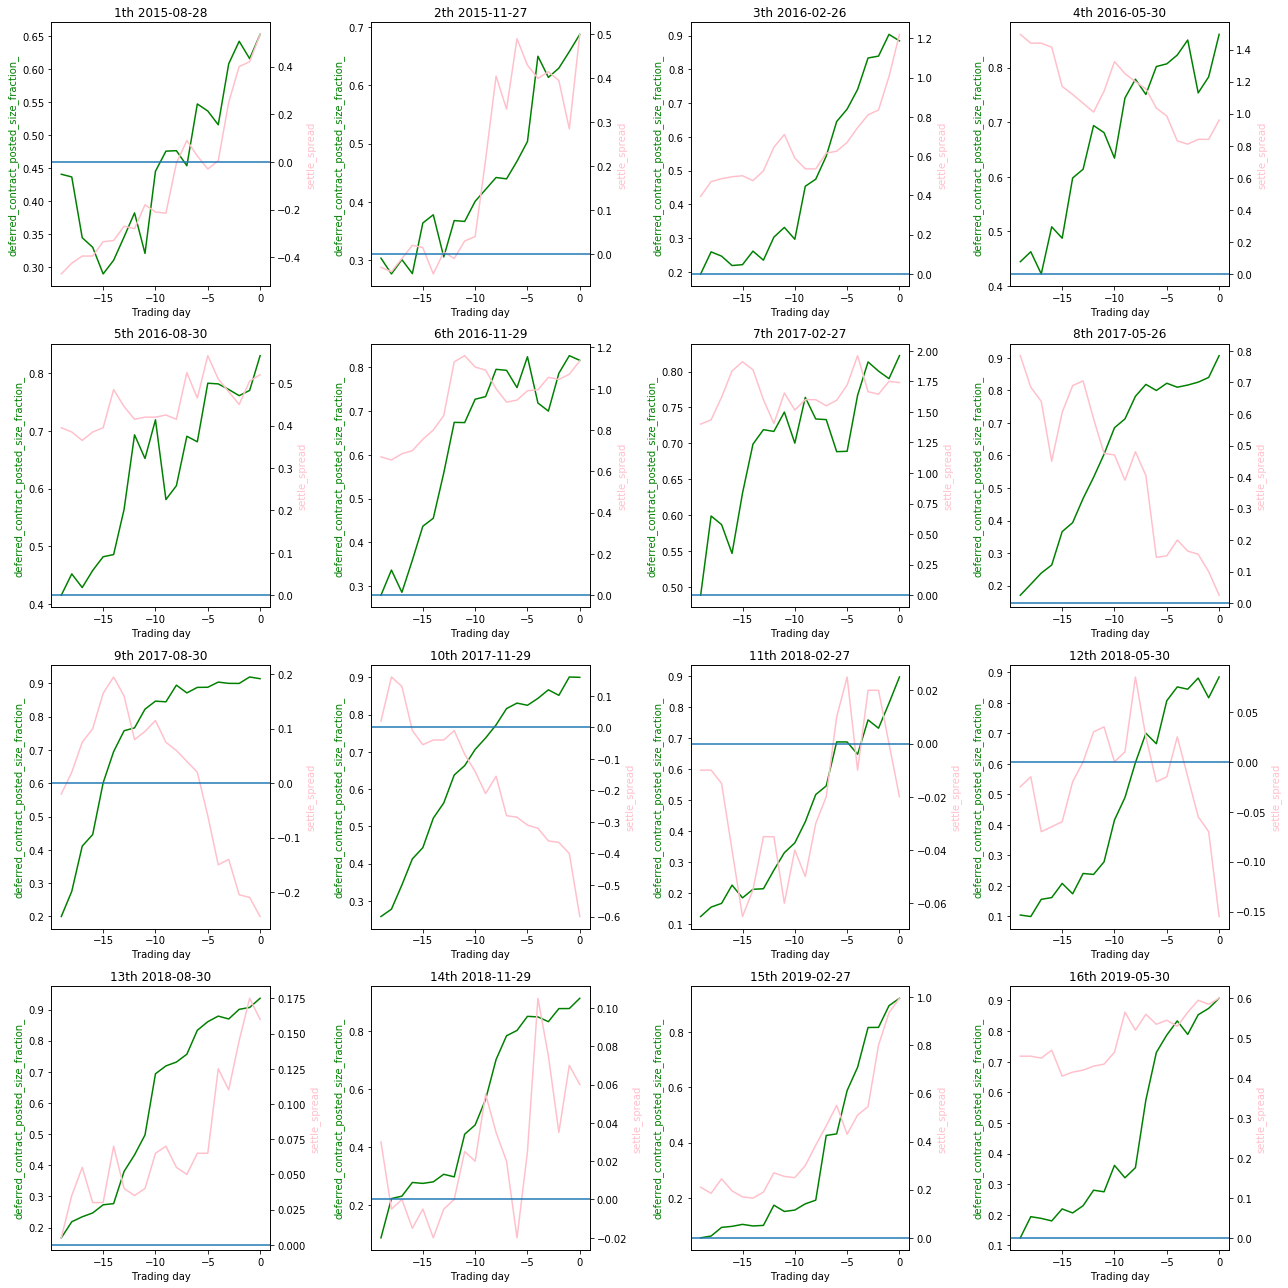

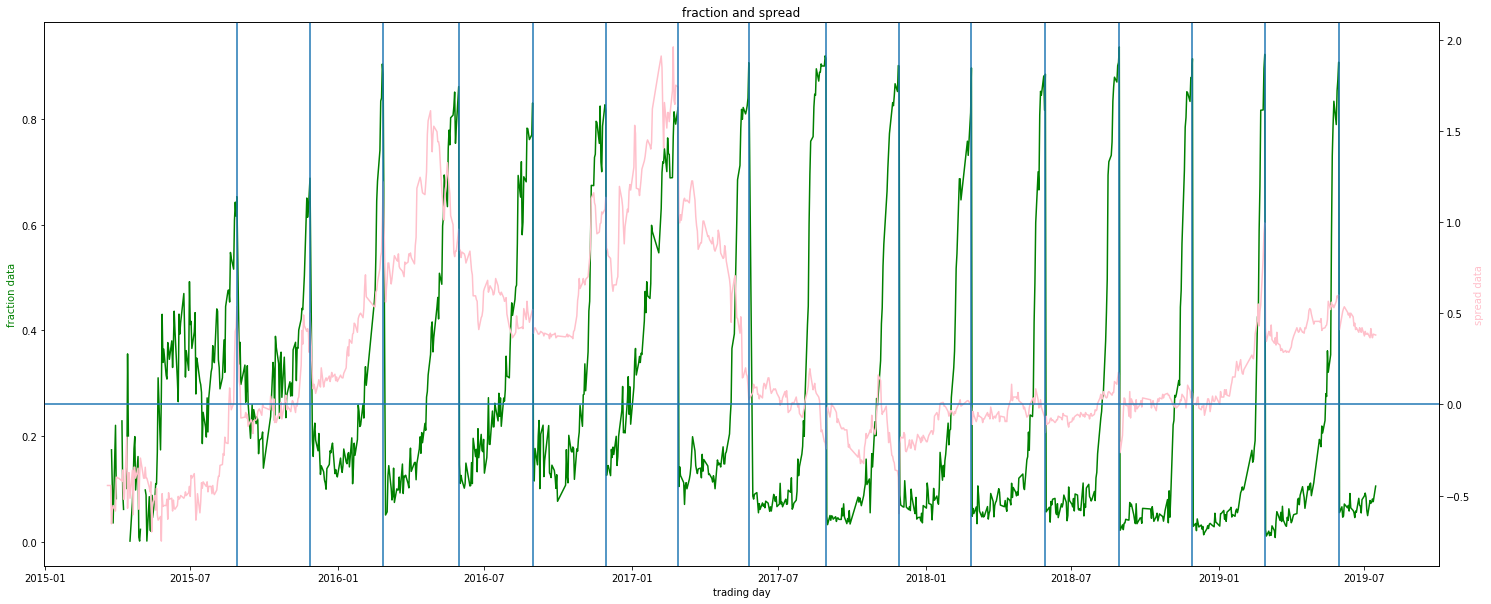

In [76]:
draw_roll_period_only(T_spread_data, T_fraction_data, T_contracts_sequence, T_delivery_info, T_contract_list, 20, 
                          fraction='posted_size', spread='settle', fraction_type='deferred')

# TF Posted Size

In [78]:
TF_spread_data = pd.read_csv('../data/interim/raw_features/TF/TF_Settle.csv', index_col='Trading_Day', parse_dates=True)
TF_fraction_data = pd.read_csv('../data/interim/raw_features/TF/TF_Posted_Size.csv', index_col='Trading_Day', parse_dates=True)

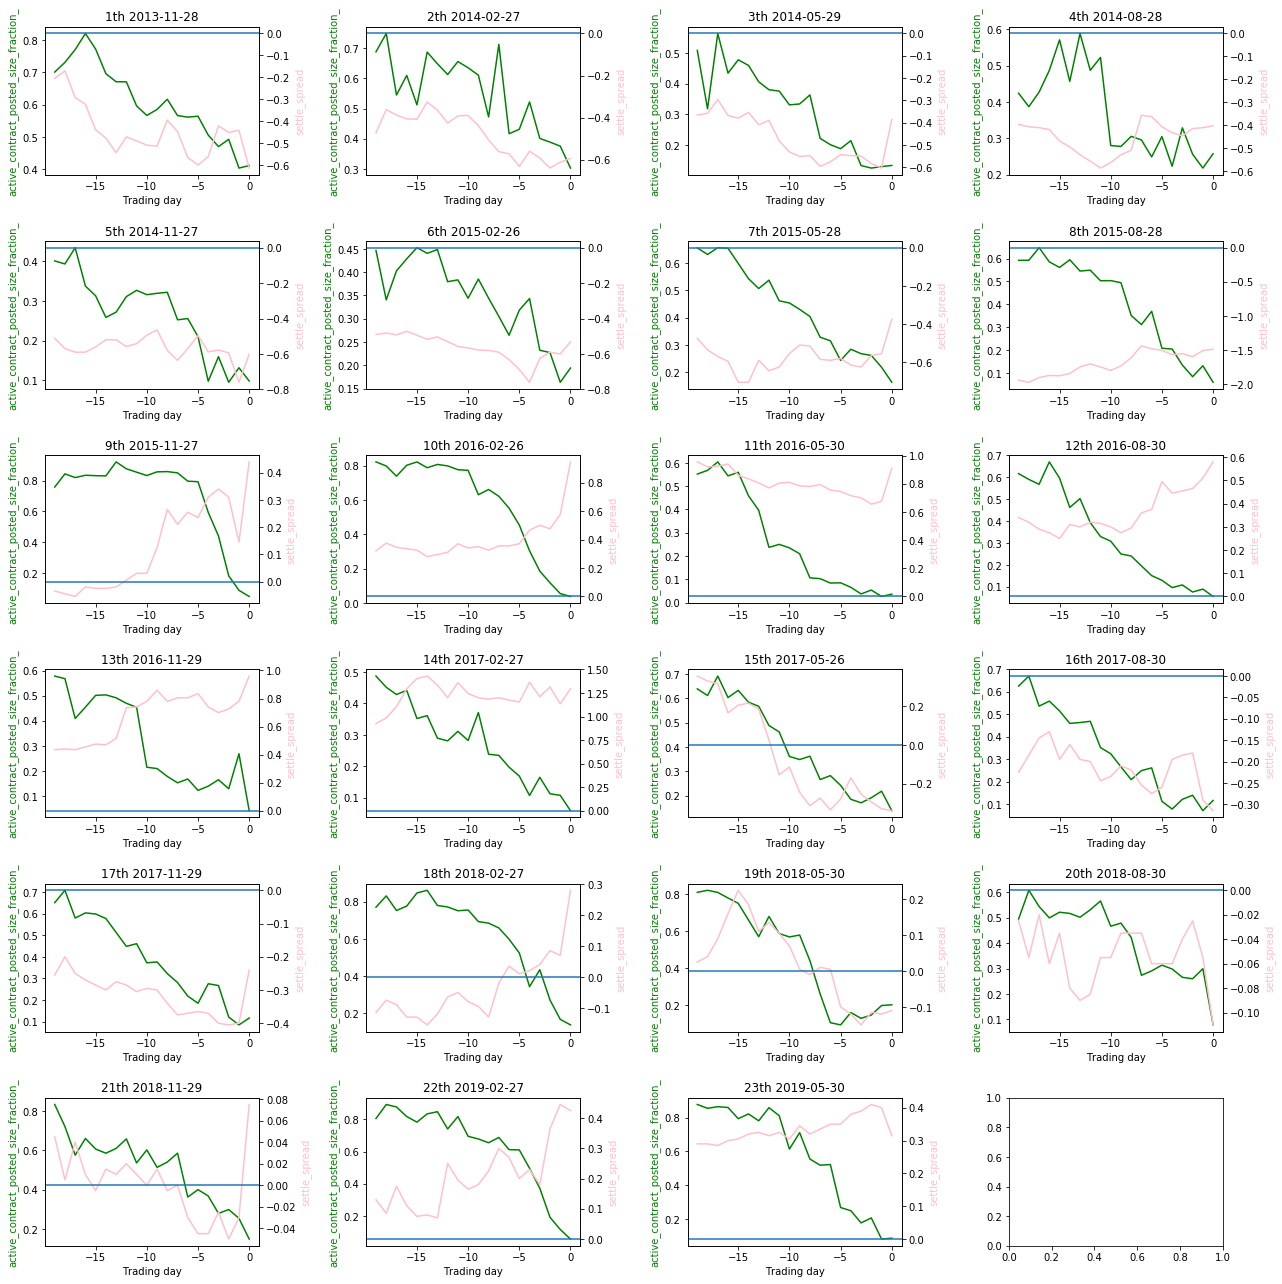

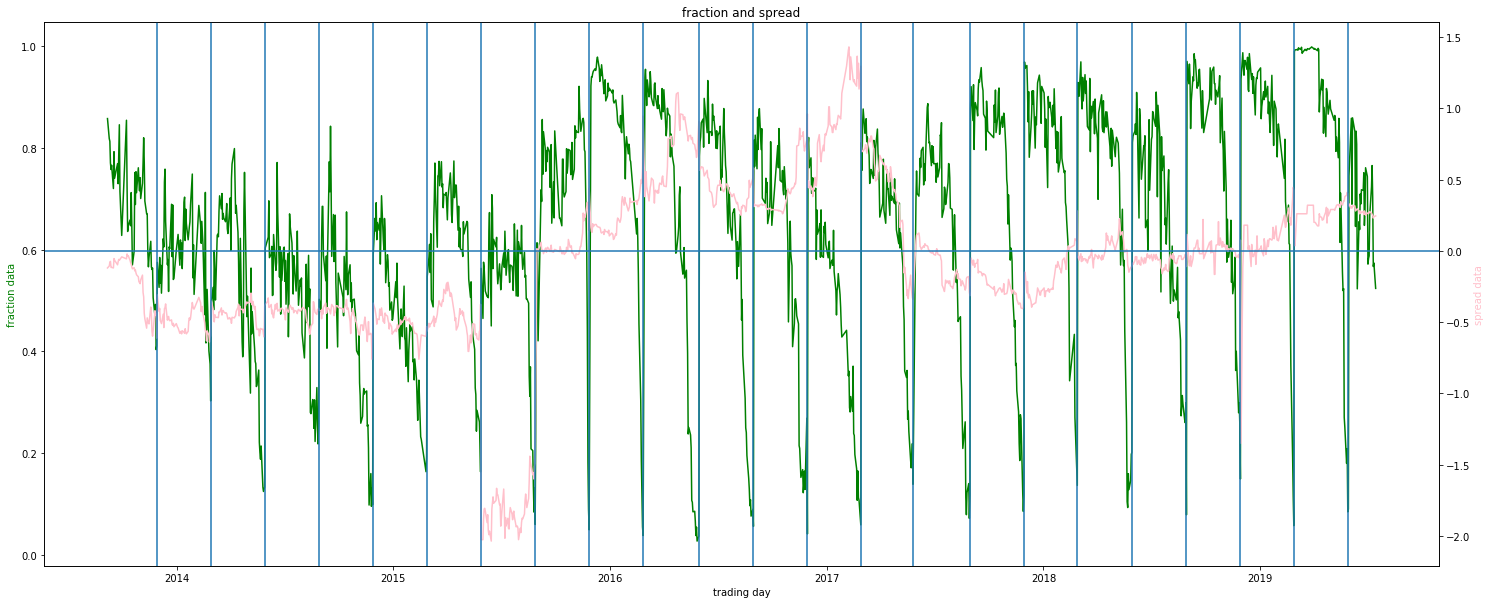

In [80]:
draw_roll_period_only(TF_spread_data, TF_fraction_data, TF_contracts_sequence, TF_delivery_info, TF_contract_list, 20, 
                          fraction='posted_size', spread='settle', fraction_type='active')

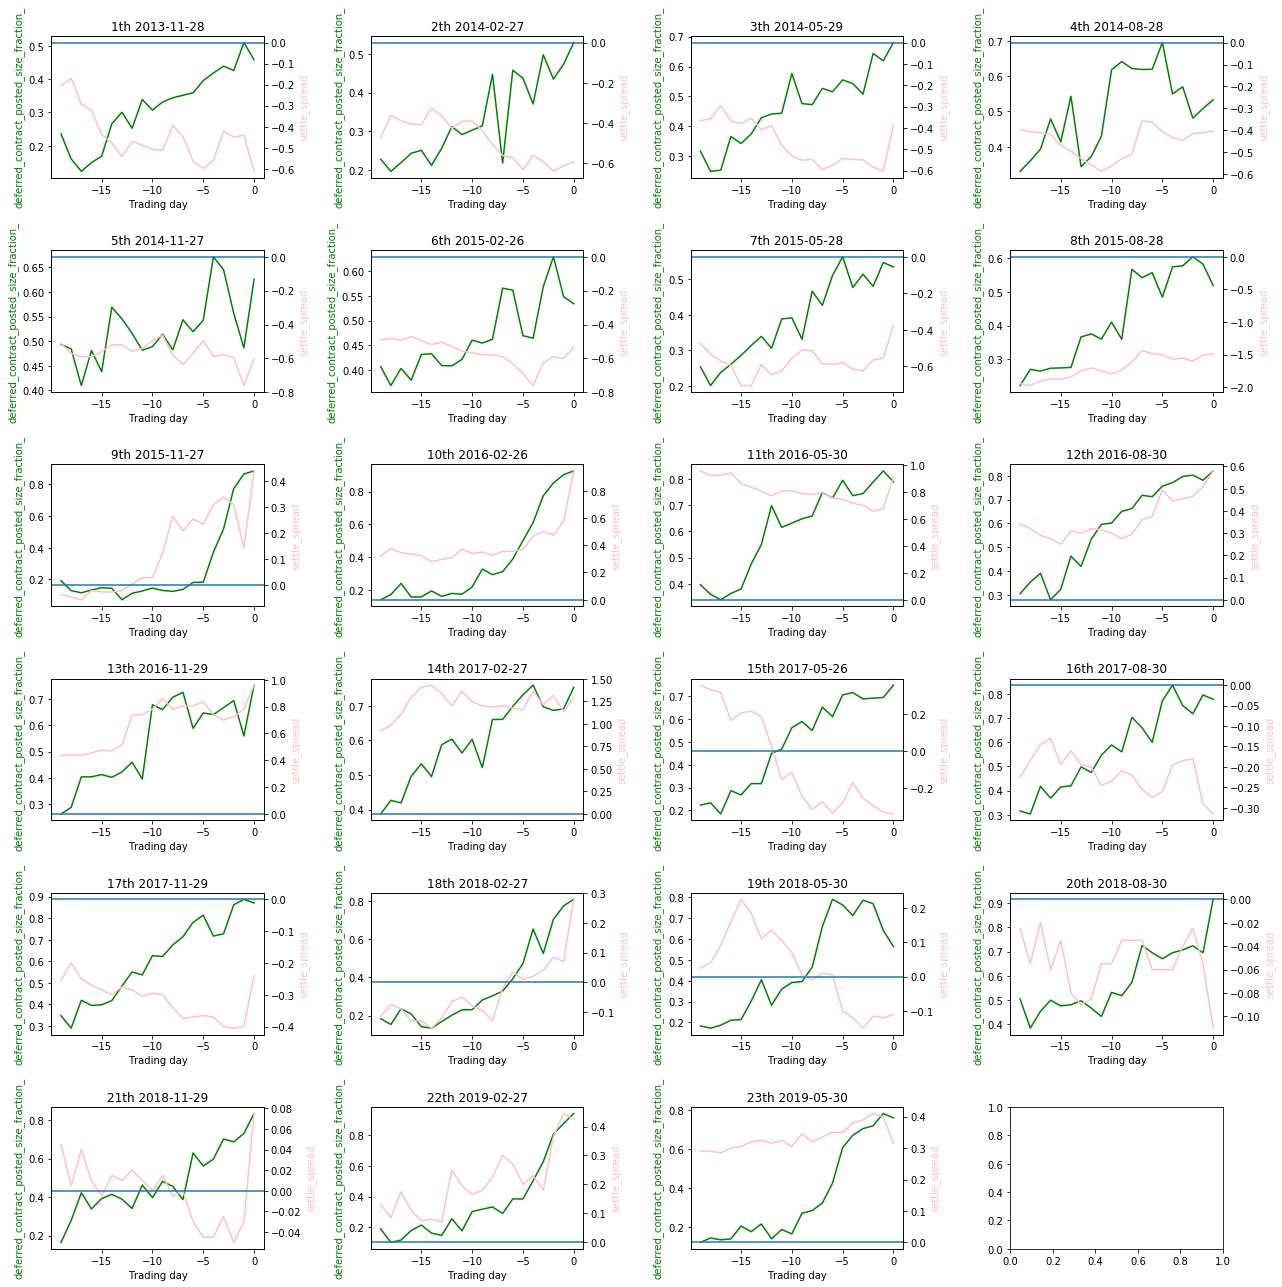

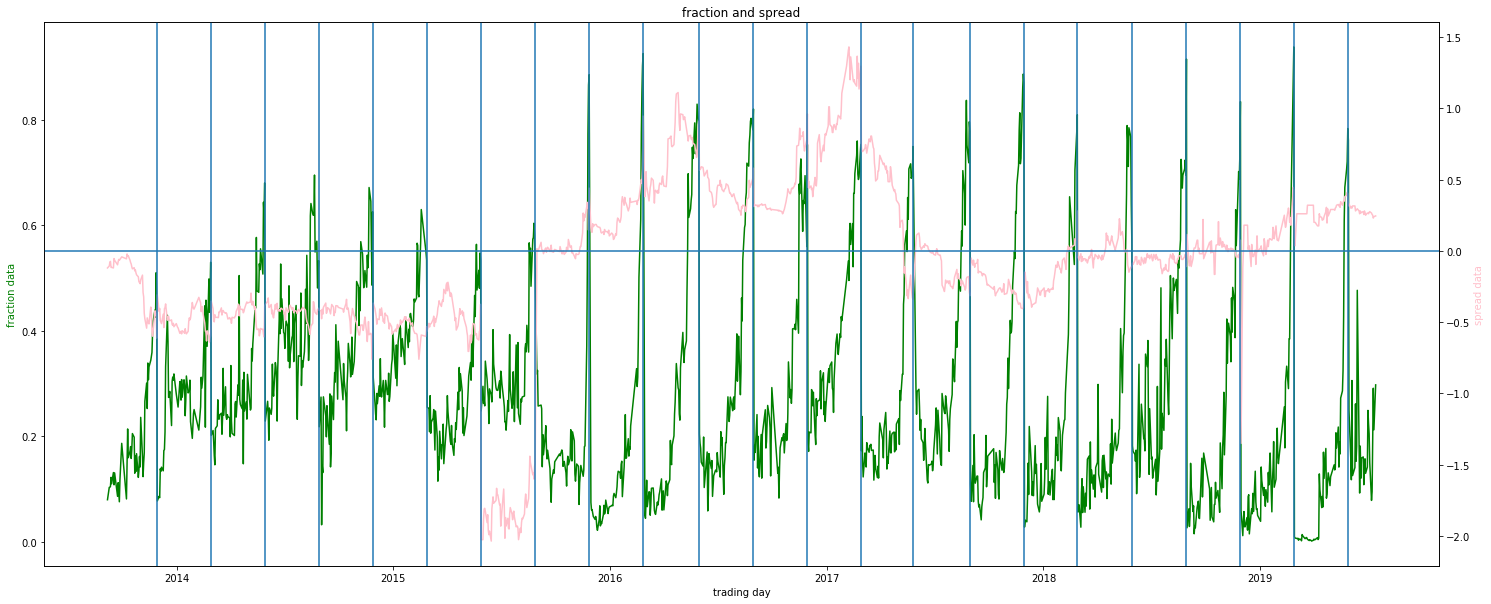

In [81]:
draw_roll_period_only(TF_spread_data, TF_fraction_data, TF_contracts_sequence, TF_delivery_info, TF_contract_list, 20, 
                          fraction='posted_size', spread='settle', fraction_type='deferred')